In [14]:
%matplotlib inline

In [2]:
from linescanning import prf
import numpy as np
from scipy.stats import ttest_rel
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
from statsmodels.stats.weightstats import DescrStatsW
import random
from prfpy import stimulus
import yaml
from scipy import io
from copy import deepcopy
import matplotlib.patches as mpatches 
from matplotlib import gridspec

opd = os.path.dirname
opj = os.path.join

## <h1> Analysis of the effect of memantine on V1 pRF characteristics </h1>
This notebook is used to calculate the effect of memantine on neuronal responses in V1, assessed using pRF modeling with the divisive normalization (DN) model. It consists of several parts. The first part involves the calculation of the effect of memantine on the linearized pRF profile P(x) at different eccentricities. The second part involves assessing the effect of memantine on the temporal response to a bar sweep, both in measured BOLD response and predicted model response. The third part involves testing differences in nonlinear spatial summation using response profile r(s). The last part involves testing individual (and derivative) DN model parameters to assess the effect of memantine on individal model parameters.

In [3]:
# First, load necessary settings for pRF analysis

with open('/data1/projects/Meman1/projects/pilot/code/floris/prf_analysis.yml') as f:
    analysis_info = yaml.safe_load(f)

dm = io.loadmat(opj('/data1/projects/Meman1/projects/pilot/code', 'design_task-2R.mat'))['stim']

# define the pRF stimulus
prf_stim = stimulus.PRFStimulus2D(
    screen_size_cm=analysis_info['screen_size_cm'],
    screen_distance_cm=analysis_info['screen_distance_cm'],
    design_matrix=dm[:,:,5:40],
    TR=analysis_info['TR'])

prf_stim2 = stimulus.PRFStimulus2D(
    screen_size_cm=analysis_info['screen_size_cm'],
    screen_distance_cm=analysis_info['screen_distance_cm'],
    design_matrix=dm[:,:,5:],
    TR=analysis_info['TR'])

ss = prf_stim.screen_size_degrees
max_ecc_size = ss/2.0

In [4]:
# Define bounds for fitting
norm_bounds = {'x':(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
               'y':(-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
               'prf_size': (0.2, 1.5*ss),  # prf size
               'A': (0,1000),  # prf amplitude
               'C': tuple(analysis_info['norm']['surround_amplitude_bound']),  # surround amplitude
               'surr_size': (0.1, 3*ss),  # surround size
               'B': tuple(analysis_info['norm']['neural_baseline_bound']),  # neural baseline
               'D': tuple([float(item) for item in analysis_info['norm']['surround_baseline_bound']])} # surround baseline

In [5]:
# Define randomization
conditions = {
    'sub-001': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-002': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-003': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-004': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-005': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-007': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-008': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-010': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-012': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-013': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-015': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-016': {'memantine': 'ses-2', 'placebo': 'ses-3'}
}

# All subs but with sub-015 excluded for group analyses
newsubs = ['sub-001','sub-002','sub-003','sub-004','sub-005','sub-007','sub-008','sub-010','sub-012','sub-013','sub-016']

minr2=0.1
minecc=0.5 #The minimum
maxecc=4.5 #The maximum eccentricity you want to use
deriv='/data1/projects/Meman1/projects/pilot/derivatives'
model='norm'

placebo_patch = mpatches.Patch(color='royalblue', label='placebo')
memantine_patch = mpatches.Patch(color='firebrick', label='memantine')

In [6]:
class Add_pRF_profile:
    # Class to do some filtering on a pRFmodelFitting object on Gaussian model. You mainly specify the eccentricities that you want to look at, your minimum r2, and potentially a ROI
    # It returns an object with most of the characteristics of the pRFmodelFitting, but also adds FWHM and FWMIN
    
    def __init__(self,
                 pRFmodelFitting=None,
                 data=None,
                 design=None,
                 model=None,
                 stage=None,
                 params=None,
                 roi=None,
                 excludenegampl=False,
                 normalizeprofile=False,
                 eccmask=[minecc, maxecc],
                 r2mask=minr2):
        
        self.pRFmodelFitting=pRFmodelFitting
        if isinstance(self.pRFmodelFitting, prf.pRFmodelFitting):
            # if pRFmodelFitting object, get the necessary settings from here
            self.data=self.pRFmodelFitting.data
            self.model=self.pRFmodelFitting.model
            self.stage=self.pRFmodelFitting.stage
            self.params=prf.Parameters(params=getattr(self.pRFmodelFitting, f"{self.model}_{self.stage}"), model=self.model).to_df()
            self.design=self.pRFmodelFitting.design_matrix

        else:
            # else, take from manual input
            self.data=data
            self.model=model
            self.stage=stage
            self.params=params
            self.design=design
            
        # some additional settings
        self.excludenegampl=excludenegampl
        self.normalizeprofile=normalizeprofile
        self.eccmask=eccmask
        self.r2mask=r2mask
        self.roi=roi

        # select vertices based on roi...
        if self.roi is not None:
            try:
                self.params=self.params.loc[self.roi]
                print("ROI has", len(self.roi), "values")
            except:
                print("Not a valid ROI, give an array with vertex numbers for the ROI")
                print(len(self.roi))
                
        # drop vertices based on eccentricity and r2 boundaries
        self.params.loc[self.params['ecc'].values < self.eccmask[0]] = np.nan
        self.params.loc[self.params['ecc'].values > self.eccmask[1]] = np.nan
        self.params.loc[self.params['r2'].values < self.r2mask] = np.nan

        # drop vertices based on biological plausibility
        self.params.loc[self.params['surr_size'].values < self.params['prf_size'].values] = np.nan
        self.params.loc[self.params['prf_size'].values < 1.01*norm_bounds['prf_size'][0]] = np.nan

        print("Excluding", self.params.isna().any(axis=1).sum(), 'vertices based on mask...')
        self.params=self.params.dropna()

        # drop vertices if they have a negative pRF amplitude
        if self.excludenegampl:
            self.params.loc[self.params['prf_ampl'].values < 0] = np.nan
            print("Excluding", self.params.isna().any(axis=1).sum(), 'negative pRFs...')
            self.params=self.params.dropna()
        
        # initialize profile characteristics
        self.x = np.linspace(-10,10,2000).astype('float32')
        self.profile_df = pd.DataFrame(index=self.params.index, columns=self.x)

        # function to calculate profile, fwhm given an Add_pRF_profile object and a vertex index
        def profile_fwhm_fwmin(self, index):
            x = self.x
            params = self.params.loc[index]

            # calculate the activation pRF profile (and the volume underneath pRF)
            profile_act = params.prf_ampl * np.exp(-0.5*(x**2) / (params.prf_size**2))
            volume_act = np.sqrt(2*np.pi*(params.prf_size**2)) # NOT USED NOW, CAN BE USED LATER!!

            if self.model=='gauss':
                # calculate halfmax and fwhmax
                half_max = np.max(profile_act, axis=0)/2
                fwhmax = np.abs(2*x[np.argmin(np.abs(profile_act-half_max), axis=0)])

                return fwhmax, half_max
            
            elif self.model=='norm':
                # calculate the normalization pRF profule (and the volume underneath pRF)
                profile_norm = params.surr_ampl * np.exp(-0.5*(x**2) / (params.surr_size**2))
                volume_norm = np.sqrt(2*np.pi*(params.surr_size**2)) # NOT USED NOW, CAN BE USED LATER!!

                # calculate full profile based on constants, profile act, and profile norm
                profile = (profile_act + params.B)/(profile_norm + params.D) - (params.B/params.D)
                
                # normalize RFs if necessary
                if self.normalizeprofile:
                    profile /= np.max(profile)

                # calculate halfmax and fwhmax
                half_max = np.max(profile, axis=0)/2
                fwhmax = np.abs(2*x[np.argmin(np.abs(profile-half_max), axis=0)])

                minim = np.min(profile, axis=0)
                maxim = np.max(profile, axis=0)

                fwmin= np.abs(2*x[np.argmin(profile, axis=0)])                

                # if fwmin is this large, it does not make any sense really as there is no visible surround. leaving it in would create an outlier    
                if fwmin==float(20.0):
                    fwmin=np.nan
                
                if minim>0 or maxim<0.01 or profile[999]<maxim:
                    fwhmax=np.nan
                    half_max=np.nan
                    minim=np.nan
                    maxim=np.nan
                    fwmin=np.nan
                    
                return fwhmax, half_max, minim, maxim, fwmin

        # now, add the profile measures to the dataframe
        if self.model=='gauss':
            for vert in self.params.index:
                fwhmaxx, half_maxx = profile_fwhm_fwmin(self, vert)
                self.params.loc[vert, 'fwhm'] = fwhmaxx
                self.params.loc[vert, 'half_max'] = half_maxx

        elif self.model=='norm':
            for vert in self.params.index:
                fwhmaxx, half_maxx, minimm, maximm, fwminn = profile_fwhm_fwmin(self, vert)
                if abs(minimm)/maximm == np.inf:
                    print(vert)
                self.params.loc[vert, 'fwhm'] = fwhmaxx
                self.params.loc[vert, 'half_max'] = half_maxx
                self.params.loc[vert, 'minimum'] = minimm
                self.params.loc[vert, 'maximum'] = maximm
                self.params.loc[vert, 'min/max'] = minimm/maximm
                self.params.loc[vert, 'fwmin'] = fwminn
                self.params.loc[vert, 'basetopeak']= np.abs(maximm-minimm)

<h2>0. Extracting DN model parameters for all subjects in both conditions </h2>

In [7]:
# Here, I will store all output after looping over the subjects
prffits = {
    sub: {
        'fits': {'placebo': None, 'memantine': None},
        'roi_vertices': {'V1_vertices': None, 'V2_vertices': None, 'V3_vertices': None}
    } for sub in conditions.keys()}

In [8]:
for sub in conditions.keys():
    print(f"Working on subject {sub}...")
    print("")

    #######################################################
    ###### LOADING IN ROIs ################
    #######################################################

    print("Getting ROI vertices...")
    print("")

    finalrois= opj(deriv, 'freesurfer',sub, 'customlabel', 'roidrawing', 'final')
    
    #Load V1 vertices from left hemisphere, together with the number of vertices in the left hemisphere so indexing for right hemisphere works appropriately; the .label files start from 0 and work per hemisphere, whereas Inkscape merges the two hemispheres together.
    V1_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V1.label'))
    V2_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V2.label'))
    V3_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V3.label'))

    all_lh = nib.freesurfer.read_geometry(opj(deriv, 'freesurfer', sub, 'surf', 'lh.inflated'))

    #Load V1 vertices from right hemisphere. 
    V1_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V1.label'))
    V2_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V2.label'))
    V3_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V3.label'))

    all_rh = nib.freesurfer.read_geometry(opj(deriv, 'freesurfer', sub, 'surf', 'rh.inflated'))

    # Get the right indices for the right hemisphere by adding the number of vertices in left hemisphere to the ROI indices for the right hemisphere.
    V1_rh = V1_rh + len(all_lh[0])
    V2_rh = V2_rh + len(all_lh[0])
    V3_rh = V3_rh + len(all_lh[0])

    # Concatenate the 2 and sort them such that they are in the right order
    V1_vertices = np.sort(np.concatenate([V1_lh, V1_rh]))
    V2_vertices = np.sort(np.concatenate([V2_lh, V2_rh]))
    V3_vertices = np.sort(np.concatenate([V3_lh, V3_rh]))

    roi_vertices = np.sort(np.concatenate([V1_vertices, V2_vertices, V3_vertices]))

    prffits[sub]['roi_vertices']['V1_vertices'] = V1_vertices
    prffits[sub]['roi_vertices']['V2_vertices'] = V2_vertices
    prffits[sub]['roi_vertices']['V3_vertices'] = V3_vertices

    for condition in ['placebo', 'memantine']:
        print(f"Working on {condition}...")
        print("")

        # First, get path to the appropriate files
        design = prf.read_par_file(opj(deriv, 'prf', sub, 'design_task-2R.mat'))
        outputdata = opj('/data1/projects/Meman1/projects/pilot/code/floris/output', sub)

        # Load data
        data = np.load(opj(deriv, 'prf', sub, conditions[sub][condition], f'{sub}_{conditions[sub][condition]}_task-2R_hemi-LR_desc-avg_bold.npy'))

        # Initialize empty array of parameters with the appropriate shape
        params_norm = np.zeros(shape=(data.shape[1], 12))

        #######################################################
        ###### GETTING ALL PARAMETERS IN RIGHT SPOT ###########
        #######################################################

        print("Putting parameters in right place...")
        print("")

        for i in range(20):
            roivertices = np.load(opj(outputdata, 'roivertices', f'roivertices_{sub}_slice-{i}.npy'))
            paramss= np.load(opj(outputdata, 'fits', f'{sub}_{conditions[sub][condition]}_task-2R_model-norm_stage-iter_desc-prfparams_slice-{i}.npy'))

            for index, roivertex in enumerate(roivertices):
                params_norm[roivertex] = paramss[index]

        #######################################################
        ###### LOADING IN PARAMETERS IN OBJECT ################
        #######################################################
        print("Creating pRFmodelFitting object...")
        print("")
        
        # initialize empty model
        norm_obj= prf.pRFmodelFitting(
            data.T,
            design_matrix=design,
            TR=1.5,                     # default
            model=model,                # default, can be 'gauss', 'css', 'dog', 'norm'
            stage="iter",               # default
            verbose=True,               # keep track of what we're doing,
            fix_bold_baseline=True      # fix the BOLD baseline at 0
        )

        # load params
        norm_obj.load_params(params_norm, model=model, stage="iter")

        #######################################################
        ###### CREATING AN ADD_PRF_PROFILE OBJ ################
        #######################################################
        print("Creating an Add_pRF_profile...")
        print("")

        norm_filtered = Add_pRF_profile(norm_obj, r2mask=0.1, eccmask=[0.5, 4.5], roi=roi_vertices) # You can change things here in the settings if you want

        #######################################################
        ###### ADDING TO DICTIONARY NOW     ###################
        #######################################################

        prffits[sub]['fits'][condition] = norm_filtered

Working on subject sub-001...

Getting ROI vertices...

Working on placebo...

Putting parameters in right place...

Creating pRFmodelFitting object...

Design has 5 more volumes than timecourses, trimming from beginning of design to (100, 100, 220)
Reading settings from '/data1/projects/Meman1/projects/pilot/code/prf_analysis.yml'

---------------------------------------------------------------------------------------------------
Check these important settings!
 Screen distance: 196cm
 Screen size: 39.3cm
 TR: 1.5s
---------------------------------------------------------------------------------------------------

Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0] (fit=True)
Using constraint(s): ['tc', 'tc']
Inserting parameters from <class 'numpy.ndarray'> as 'norm_iter' in <linescanning.prf.pRFmodelFitting object at 0x7f56cec8d7f0>
Creating an Add_pRF_profile...

ROI has 4374 values
Excluding 554 vertices based on mask...
Working on memantine...

Putting parameters in right p

In [9]:
def get_descriptives(row, param, weighted=False):
    ## This is a function to quickly get descriptive metric for individual pRF parameters, weighted by the R2 of individual vertices
    
    totest = row.dropna(subset=param)

    if weighted:
        descriptives = DescrStatsW(totest[param], weights=totest['r2'])
        mean = descriptives.mean
        std = descriptives.std
        n = len(totest)
        sem = std/np.sqrt(n)
    else:
        mean = totest[param].mean()
        std = totest[param].std()
        n = len(totest)
        sem = std/np.sqrt(n)
    
    return mean, std, sem

In [10]:
def profile_fwhm_fwmin(params, normalizeprofile=False, model='norm'):
    ## This is a function to calculate the linearized pRF profile of individual vertices based on model parameters

    x = np.linspace(-10,10,2000)

    # calculate the activation pRF profile (and the volume underneath pRF)
    profile_act = params['A'] * np.exp(-0.5*(x**2) / (params['prf_size']**2))
    volume_act = np.sqrt(2*np.pi*(params['prf_size']**2)) # NOT USED NOW, CAN BE USED LATER!!

    if model=='gauss':
        return profile_act
            
    elif model=='norm':
        # calculate the normalization pRF profule (and the volume underneath pRF)
        profile_norm = params['C'] * np.exp(-0.5*(x**2) / (params['surr_size']**2))
        volume_norm = np.sqrt(2*np.pi*(params['surr_size']**2)) # NOT USED NOW, CAN BE USED LATER!!

        # calculate full profile based on constants, profile act, and profile norm
        profile = (profile_act + params['B'])/(profile_norm + params['D']) - (params['B']/params['D'])
                
        # normalize RFs if necessary
        if normalizeprofile:
            profile /= np.max(profile)

        # calculate halfmax and fwhmax
        half_max = np.max(profile, axis=0)/2
        fwhmax = np.abs(2*x[np.argmin(np.abs(profile-half_max), axis=0)])

        minim = np.min(profile, axis=0)
        maxim = np.max(profile, axis=0)

        fwmin= np.abs(2*x[np.argmin(profile, axis=0)])                

        # if the profile has these weird characteristics    
        if fwmin==float(20.0) or minim>0 or maxim<0.01 or profile[999]<maxim:
            profile = np.empty((0,2000))
        
        return profile

In [11]:
def get_mean_profile(profilearray, weighted=False, weights=None):
    ## This is a function to calculate descriptive metrics of an array of pRF responses for different vertices, potentially weighted by R2 
    
    if weighted:
        mean_profile = DescrStatsW(profilearray, weights=weights)
        mean = mean_profile.mean
        std = mean_profile.std
        n = profilearray.shape[0]
        sem = std/np.sqrt(n)
        ci = 1.96*sem

    else:
        mean = profilearray.mean(axis=0)
        std = profilearray.std(axis=0)
        n = profilearray.shape[0]
        sem = std/np.sqrt(n)
        ci = 1.96*sem
    
    return mean, std, sem, ci

In [12]:
# SAY HERE IF YOU WANT ANALYSIS TO BE WEIGHTED BY R2 OR NOT
weighted = True

<h2> 1. Calculate effect of eccentricity on relative minimum of pRF profile </h2>

In [13]:
# Characteristics of eccentricity bins
num_bins=20
bin_edges = np.linspace(0.5,4.5, num_bins+1)
metric = 'min/max'

# Calculate the necessary metrics for all the subjects and saving them
meandict = {
    sub: {
        condition: {
            'scatter': {},
            'profile': {'mean': {}, 'ci': {}},
            'bar': {}
        } for condition in ['placebo', 'memantine']
    } | {'difference': {}}
    for sub in conditions.keys()}

# Plot 1: Metric versus Eccentricity in both conditions
for index, sub in enumerate(conditions.keys()):

    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    # only select vertices that had r2>0.3 for at least one of the conditions
    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>0.3 or 
                                prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>0.3)]
    
    ############## 1. CALCULATE DIFFERENCES #####################
    filtered_params_plac = prffits[sub]['fits']['placebo'].params.loc[valid_vertices_V1_shared]
    filtered_params_mem = prffits[sub]['fits']['memantine'].params.loc[valid_vertices_V1_shared]
    
    # Create new dataframe with differences
    diff_df = pd.DataFrame(columns=['vertex_nr', f'{metric} diff', 'mean_ecc','mean_r2'])

    diff_df['vertex_nr'] = valid_vertices_V1_shared

    diff_df[f'{metric} diff'] = filtered_params_plac[metric].values-filtered_params_mem[metric].values

    for param in ['ecc','r2']:
        diff_df[f'mean_{param}'] = np.mean([filtered_params_plac[param], filtered_params_mem[param]], axis=0)

    # Now, calculate the difference while grouped in eccentricity bins
    shapemetrics_V1 = diff_df.dropna(subset=f'{metric} diff')

    # Calculate eccentricity bins for each ROI
    shapemetrics_V1['eccentricity_bin'] = pd.qcut(shapemetrics_V1['mean_ecc'], q=num_bins, labels=range(20))

    # Calculate mean for each group
    df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: np.average(x['mean_ecc'], weights=x['mean_r2']))
    df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: np.average(x[f'{metric} diff'], weights=x['mean_r2']))
    
    # Put in the dictionary
    meandict[sub]['difference']['mean_ecc'] = df_mean_ecc_v1
    meandict[sub]['difference']['mean_metric'] = df_mean_metric_v1

    for index, condition in enumerate(['placebo', 'memantine']):
        
        ############## 2. CALCULATE ECCENTRICITY VS METRIC PER CONDITION  ###################
        shapemetrics_V1 = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared].dropna(subset=metric)

        # Calculate eccentricity bins for each ROI
        shapemetrics_V1['eccentricity_bin'] = pd.qcut(shapemetrics_V1['ecc'], q=num_bins, labels=range(20))

        # Calculate mean for each group
        df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: np.average(x['ecc'], weights=x['r2']))
        df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: np.average(x[metric], weights=x['r2']))

        df_sem_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: np.std(x[metric]) / np.sqrt(len(x[metric])))


        meandict[sub][condition]['scatter']['mean_ecc'] = df_mean_ecc_v1
        meandict[sub][condition]['scatter']['mean_metric'] = df_mean_metric_v1
        meandict[sub][condition]['scatter']['sem_metric'] = df_sem_metric_v1

        ############## 3. CALCULATE MEAN OF GROUP IN LOW VERSUS HIGH ECCENTRICITIES  ###################
        for ecc_range in [(0.5,2.5),(2.5,4.5)]:
                                
            filtered_params_ecc = shapemetrics_V1.loc[(shapemetrics_V1['ecc']>ecc_range[0]) & (shapemetrics_V1['ecc']<ecc_range[1])]
            
            mean_metric,_,_ = get_descriptives(filtered_params_ecc, 'min/max',weighted=True)

            meandict[sub][condition]['bar'][f'{ecc_range[0]}-{ecc_range[1]}'] = mean_metric     

        ############## 4. CALCULATE PROFILE PER CONDITION  ################### --> THIS CAN BE PUT IN THE OTHER LOOP
        shapemetrics_low = shapemetrics_V1[shapemetrics_V1['ecc']<2.5]
        shapemetrics_high = shapemetrics_V1[shapemetrics_V1['ecc']>2.5]

        allprofiles_low = {'vertex': [],'r2': [],'profile': []}
        allprofiles_high = {'vertex': [],'r2': [],'profile': []}
        
        for row in shapemetrics_low.iterrows():
            profile = profile_fwhm_fwmin(row[1],normalizeprofile=True)
            
            if profile.size != 0:
                allprofiles_low['vertex'].append(row[0])
                allprofiles_low['r2'].append(shapemetrics_low.loc[row[0]]['r2'])
                allprofiles_low['profile'].append(profile)

        for row in shapemetrics_high.iterrows():
            profile = profile_fwhm_fwmin(row[1],normalizeprofile=True)

            if profile.size != 0:
                allprofiles_high['vertex'].append(row[0])
                allprofiles_high['r2'].append(shapemetrics_high.loc[row[0]]['r2'])
                allprofiles_high['profile'].append(profile)
        

        # Calculate mean
        mean_low,_,_,ci_low = get_mean_profile(np.vstack(allprofiles_low['profile']), weighted=True, weights=allprofiles_low['r2'])
        mean_high,_,_,ci_high = get_mean_profile(np.vstack(allprofiles_high['profile']), weighted=True, weights=allprofiles_high['r2'])

        meandict[sub][condition]['profile']['mean']['0.5-2.5'] = mean_low
        meandict[sub][condition]['profile']['ci']['0.5-2.5'] = ci_low

        meandict[sub][condition]['profile']['mean']['2.5-4.5'] = mean_high
        meandict[sub][condition]['profile']['ci']['2.5-4.5'] = ci_high

Now, create a plot

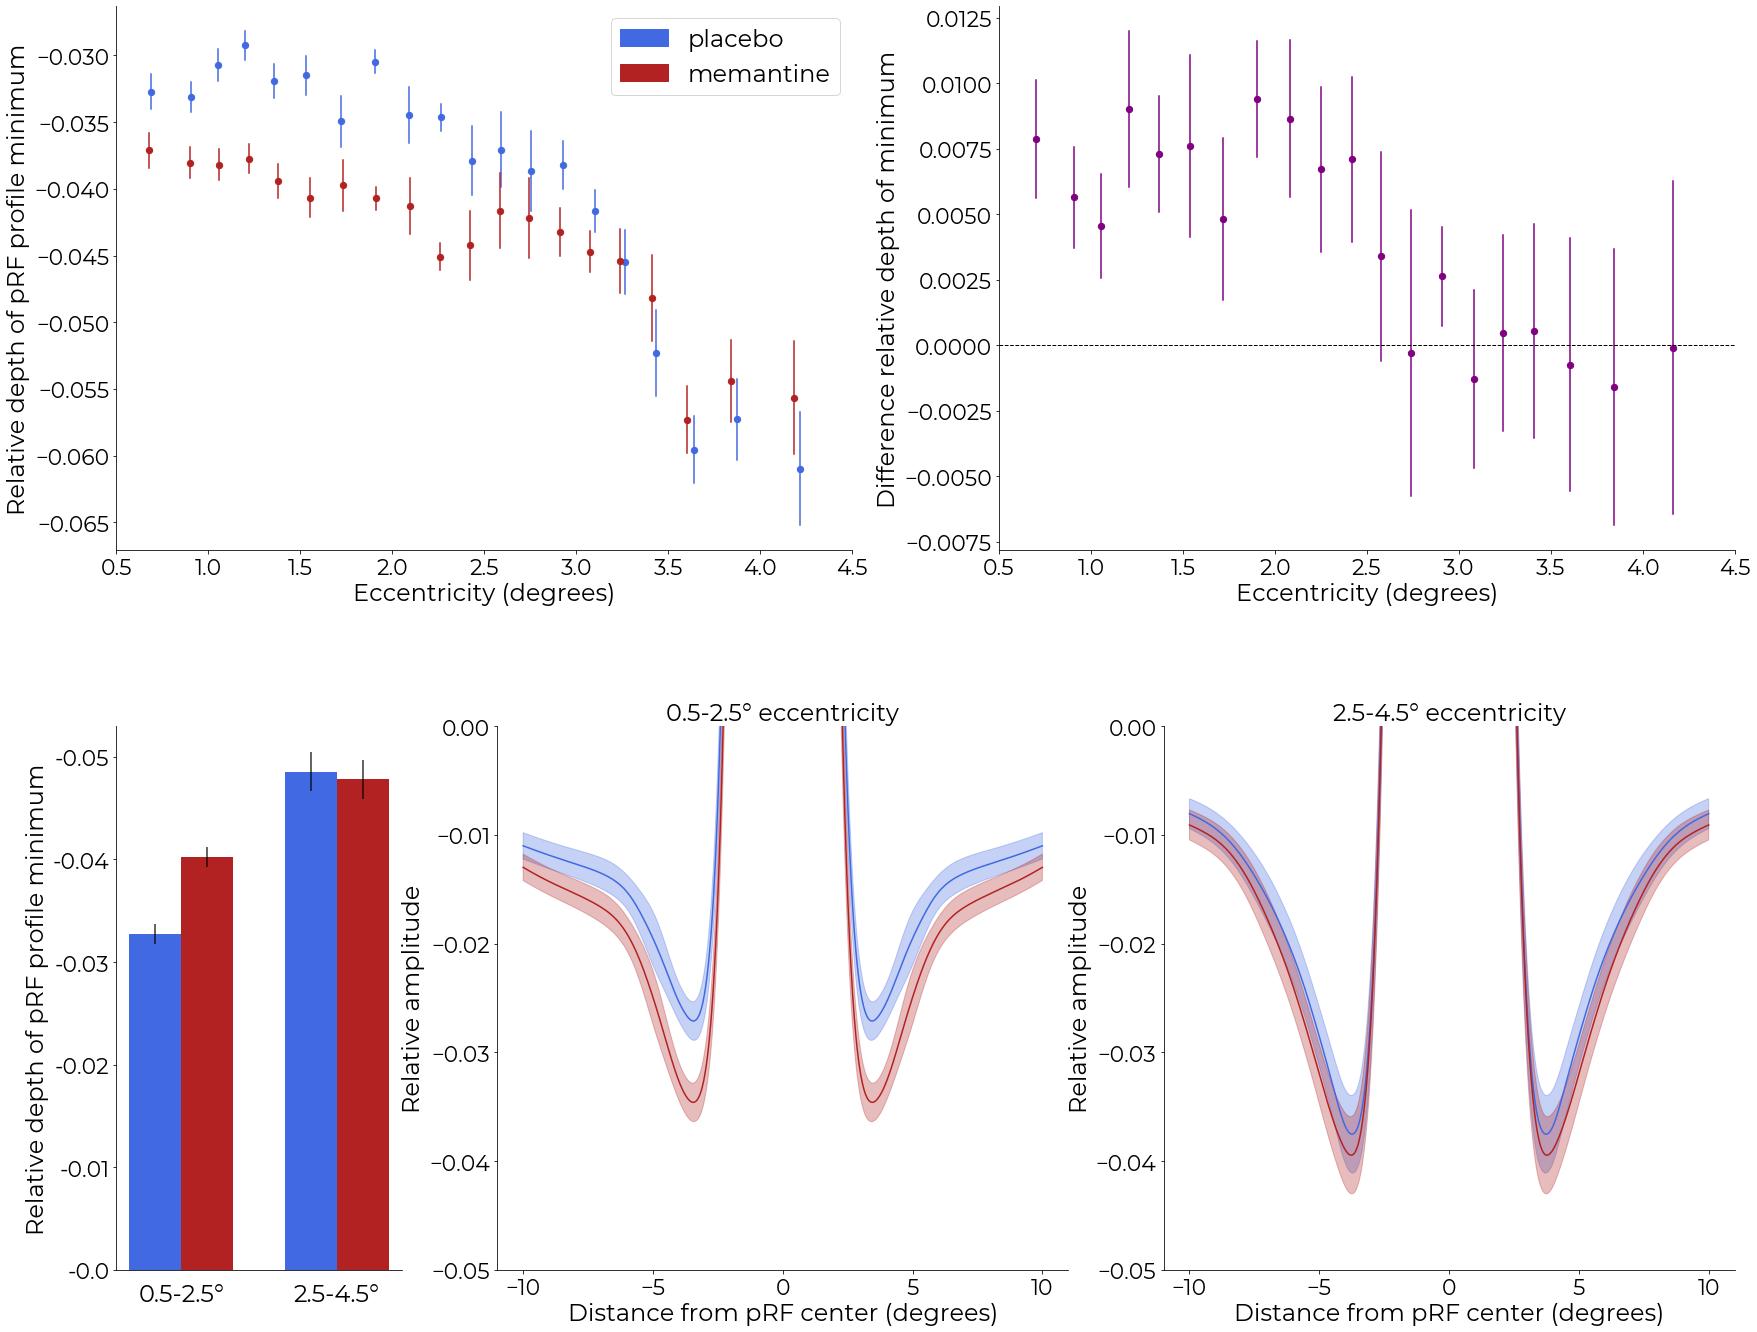

In [15]:
colorlist = {'placebo':'royalblue','memantine':'firebrick'}
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 22})

# Create the figure
fig = plt.figure(figsize=(29, 20))

subfigures = fig.subfigures(nrows=2, ncols=1)

axtop=subfigures[0].subplots(nrows=1, ncols=2)

axbottom=subfigures[1].subplots(nrows=1, ncols=3, gridspec_kw={'width_ratios': [1,2,2]})


######## PANEL A ##########

# Clean SEM calculations for all subjects:
subavgs_scatter = {sub: np.mean(np.vstack([meandict[sub][condition]['scatter']['mean_metric'].values for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
grandavg_scatter = np.mean(np.vstack([meandict[sub][condition]['scatter']['mean_metric'].values for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

meandict_scatter_corrected = {sub: {condition: meandict[sub][condition]['scatter']['mean_metric']-subavgs_scatter[sub]+grandavg_scatter for condition in ['placebo','memantine']} for sub in newsubs}

for index, condition in enumerate(['placebo', 'memantine']):
    mean_ecc_allsubs = np.mean(pd.concat([meandict[sub][condition]['scatter']['mean_ecc'] for sub in newsubs], axis=1), axis=1) # you don't need to know this SEM anyway
    mean_metric_allsubs = np.mean(pd.concat([meandict_scatter_corrected[sub][condition] for sub in newsubs], axis=1), axis=1)

    sem_metric_allsubs = np.std(pd.concat([meandict_scatter_corrected[sub][condition] for sub in newsubs], axis=1), axis=1)/np.sqrt(11)

    axtop[0].scatter(mean_ecc_allsubs, mean_metric_allsubs, color=colorlist[condition], label=condition, s=40)

    for x, y, sem in zip(mean_ecc_allsubs.values, mean_metric_allsubs.values, sem_metric_allsubs.values):
        axtop[0].plot([x, x], [y - sem, y + sem], color=colorlist[condition])
        
axtop[0].set_xlim([0.5,4.5])
axtop[0].set_ylabel('Relative depth of pRF profile minimum', fontsize=24)
axtop[0].set_xlabel('Eccentricity (degrees)', fontsize=24)
axtop[0].legend(handles=[placebo_patch, memantine_patch],fontsize=24)

######## PANEL B ##########
mean_ecc_allsubs = np.mean(pd.concat([meandict[sub]['difference']['mean_ecc'] for sub in newsubs], axis=1), axis=1)
mean_metric_allsubs = np.mean(pd.concat([meandict[sub]['difference']['mean_metric'] for sub in newsubs], axis=1), axis=1)

sem_metric_allsubs = np.std(pd.concat([meandict[sub]['difference']['mean_metric'] for sub in newsubs], axis=1), axis=1)/np.sqrt(11)

axtop[1].scatter(mean_ecc_allsubs, mean_metric_allsubs, color='purple', s=40)

for x, y, sem in zip(mean_ecc_allsubs.values, mean_metric_allsubs.values, sem_metric_allsubs.values):
    axtop[1].plot([x, x], [y - sem, y + sem], color='purple')

axtop[1].hlines(0, 0.5,4.5, linestyle='--', color='black',linewidth=1)
axtop[1].set_xlim([0.5,4.5])
axtop[1].set_ylabel('Difference relative depth of minimum', fontsize=24)
axtop[1].set_xlabel('Eccentricity (degrees)', fontsize=24)

######## PANEL C ##########
counter=0

for ecc in ['0.5-2.5', '2.5-4.5']:

    # Clean SEM calculations for all subjects:
    subavgs_bar = {sub: np.mean(np.vstack([meandict[sub][condition]['bar'][ecc] for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
    grandavg_bar = np.mean(np.vstack([meandict[sub][condition]['bar'][ecc] for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

    meandict_bar_corrected = {sub: {condition: meandict[sub][condition]['bar'][ecc]-subavgs_bar[sub]+grandavg_bar for condition in ['placebo','memantine']} for sub in newsubs}
 
    for condition in ['placebo', 'memantine']:

        mean = np.mean(np.vstack([meandict[sub][condition]['bar'][ecc] for sub in newsubs]))
        sem = np.std(np.vstack([meandict_bar_corrected[sub][condition]for sub in newsubs]))/np.sqrt(11)
        
        axbottom[0].bar(0.20*counter + 0.1, -1*mean, width=0.20, color=colorlist[condition])
        axbottom[0].vlines(0.20*counter+0.1, ymin=-mean-sem, ymax=-mean+sem, color='black', alpha=0.8)

        counter += 1
    counter += 1

axbottom[0].text(0.20, -0.003, '0.5-2.5°', horizontalalignment='center', fontsize=24)
axbottom[0].text(0.80, -0.003, '2.5-4.5°', horizontalalignment='center', fontsize=24)

axbottom[0].set_yticklabels(['-' + str(tick) for tick in axbottom[0].get_yticks()])
axbottom[0].set_xticks([])
axbottom[0].set_ylabel('Relative depth of pRF profile minimum', fontsize=24)

######### PANEL D AND E #########
for jndex, ecc in enumerate(['0.5-2.5', '2.5-4.5']):
    subavgs = {sub: np.mean(np.vstack([meandict[sub][condition]['profile']['mean'][ecc] for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
    grandavg = np.mean(np.vstack([meandict[sub][condition]['profile']['mean'][ecc] for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

    meandict_corrected = {sub: {condition: meandict[sub][condition]['profile']['mean'][ecc]-subavgs[sub]+grandavg for condition in ['placebo','memantine']} for sub in newsubs}

    for index, condition in enumerate(['placebo', 'memantine']):
        mean_allsubs = np.mean(np.vstack([meandict[sub][condition]['profile']['mean'][ecc] for sub in newsubs]), axis=0)

        sem_allsubs = np.std(np.vstack([meandict_corrected[sub][condition] for sub in newsubs]), axis=0)/np.sqrt(11)

        ci_allsubs = 1.96*sem_allsubs

        axbottom[1+jndex].plot(np.linspace(-10,10, 2000), mean_allsubs, color = colorlist[condition])
        axbottom[1+jndex].fill_between(np.linspace(-10,10, 2000), mean_allsubs-ci_allsubs, mean_allsubs+ci_allsubs, color = colorlist[condition], alpha=0.3)

        axbottom[1+jndex].set_ylim(-0.05,0)
        axbottom[1+jndex].set_xlabel('Distance from pRF center (degrees)', fontsize=24)
        axbottom[1+jndex].set_ylabel('Relative amplitude', fontsize=24)
        axbottom[1+jndex].set_title(f'{ecc}° eccentricity', fontsize=24)


sns.despine()
# Adjust the layout
plt.tight_layout()

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/V1_relativeminimum_effect.png"
# Display the plot

plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

Now, test statistically:

In [31]:
dfs = []

for sub in newsubs:
    print("Working on", sub)
    
    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>0.3 or 
                                prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>0.3)]
    
    for condition in ['placebo','memantine']:
        filtered_params = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared]
        
        for ecc_range in [(0.5,2.5),(2.5,4.5)]:
                                
            filtered_params_ecc = filtered_params.loc[(filtered_params['ecc']>ecc_range[0]) & (filtered_params['ecc']<ecc_range[1])]
            
            mean_metric,_,_ = get_descriptives(filtered_params_ecc, 'min/max',weighted=True)

            data = {'sub':sub,
                    'condition':condition,
                    'eccentricity':f'{str(ecc_range[0])}-{str(ecc_range[1])}', 
                    'minmax': mean_metric}
            
            dfs.append(data)
            
mean_metric_df = pd.DataFrame(dfs)

Working on sub-001
Working on sub-002
Working on sub-003
Working on sub-004
Working on sub-005
Working on sub-007
Working on sub-008
Working on sub-010
Working on sub-012
Working on sub-013
Working on sub-016


In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('minmax ~ eccentricity * condition + C(sub)', data=mean_metric_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                          sum_sq    df          F        PR(>F)
eccentricity            0.001501   1.0  34.070001  2.201077e-06
condition               0.000125   1.0   2.827490  1.030463e-01
C(sub)                  0.015356  10.0  34.846380  8.724873e-14
eccentricity:condition  0.000188   1.0   4.261977  4.771368e-02
Residual                0.001322  30.0        NaN           NaN


Now, post-hoc test on the interaction effect

In [33]:
print("Paired t-test for low ecc:", ttest_rel(mean_metric_df.loc[(mean_metric_df['condition'] == 'placebo') & (mean_metric_df['eccentricity'] == '0.5-2.5')]['minmax'], 
                mean_metric_df.loc[(mean_metric_df['condition'] == 'memantine') & (mean_metric_df['eccentricity'] == '0.5-2.5')]['minmax']))

print("Paired t-test for high ecc:", ttest_rel(mean_metric_df.loc[(mean_metric_df['condition'] == 'placebo') & (mean_metric_df['eccentricity'] == '2.5-4.5')]['minmax'], 
                mean_metric_df.loc[(mean_metric_df['condition'] == 'memantine') & (mean_metric_df['eccentricity'] == '2.5-4.5')]['minmax']))

Paired t-test for low ecc: Ttest_relResult(statistic=3.7966583406882477, pvalue=0.0035049379718846106)
Paired t-test for high ecc: Ttest_relResult(statistic=-0.19182214684374535, pvalue=0.8517206308958546)


Create individual bar plots for additional surround suppression measures min(P(x)) and FWMin

In [50]:
metrics = ['minimum','min/max','fwmin']

meandict_params = {sub:{condition:{metric: {} for metric in metrics} for condition in ['placebo','memantine']} for sub in conditions.keys()}

# Add subplots to the nested GridSpec
for index, sub in enumerate(meandict_params.keys()):
    print("working on",  sub)

    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>0.3 or 
                                prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>0.3)]

    for i, condition in enumerate(['placebo', 'memantine']):

        params_valid = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared]
        print(params_valid.shape)

        valid_vertices_V1_shared_lowecc = params_valid[(params_valid['ecc']>0.5) & (params_valid['ecc']<2.5)].index
        params_valid_lowecc = deepcopy(prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared_lowecc]).dropna(subset=metric)

        for metric in metrics:
            weightedstats = DescrStatsW(params_valid_lowecc[metric], weights=params_valid_lowecc['r2'])

            meandict_params[sub][condition][metric]['mean'] = weightedstats.mean
            meandict_params[sub][condition][metric]['sem'] = weightedstats.std/np.sqrt(len(params_valid_lowecc))

working on sub-001
(1060, 28)
(1060, 28)
working on sub-002
(2553, 28)
(2553, 28)
working on sub-003
(2640, 28)
(2640, 28)
working on sub-004
(2205, 28)
(2205, 28)
working on sub-005
(1945, 28)
(1945, 28)
working on sub-007
(2370, 28)
(2370, 28)
working on sub-008
(2238, 28)
(2238, 28)
working on sub-010
(1033, 28)
(1033, 28)
working on sub-012
(2193, 28)
(2193, 28)
working on sub-013
(3090, 28)
(3090, 28)
working on sub-015
(1446, 28)
(1446, 28)
working on sub-016
(2034, 28)
(2034, 28)


Test statistically using paired t-tests

In [51]:
for metric in metrics:
    print("Now testing", metric)
    param_means = {condition: [meandict_params[sub][condition][metric]['mean'] for sub in newsubs] for condition in ['placebo','memantine']}

    print("Placebo mean:", np.mean(param_means['placebo']), 'sd:', np.std(param_means['placebo']))
    print("Memantine mean:", np.mean(param_means['memantine']), 'sd:', np.std(param_means['memantine']))
    
    print(ttest_rel(param_means['placebo'],param_means['memantine']))
    print("")

Now testing minimum
Placebo mean: -0.4020280732292872 sd: 0.13832269816890813
Memantine mean: -0.5190288528819044 sd: 0.14325073990109116
Ttest_relResult(statistic=3.3449206933308484, pvalue=0.007428641575467035)

Now testing min/max
Placebo mean: -0.033193051481018546 sd: 0.017107360384093138
Memantine mean: -0.040360622313329014 sd: 0.017291434152176564
Ttest_relResult(statistic=3.752099690862977, pvalue=0.003770781727015008)

Now testing fwmin
Placebo mean: 8.035800028375194 sd: 1.1524377054910373
Memantine mean: 7.6476798306819695 sd: 0.9406300966874577
Ttest_relResult(statistic=1.6915758244710932, pvalue=0.12160198816212071)



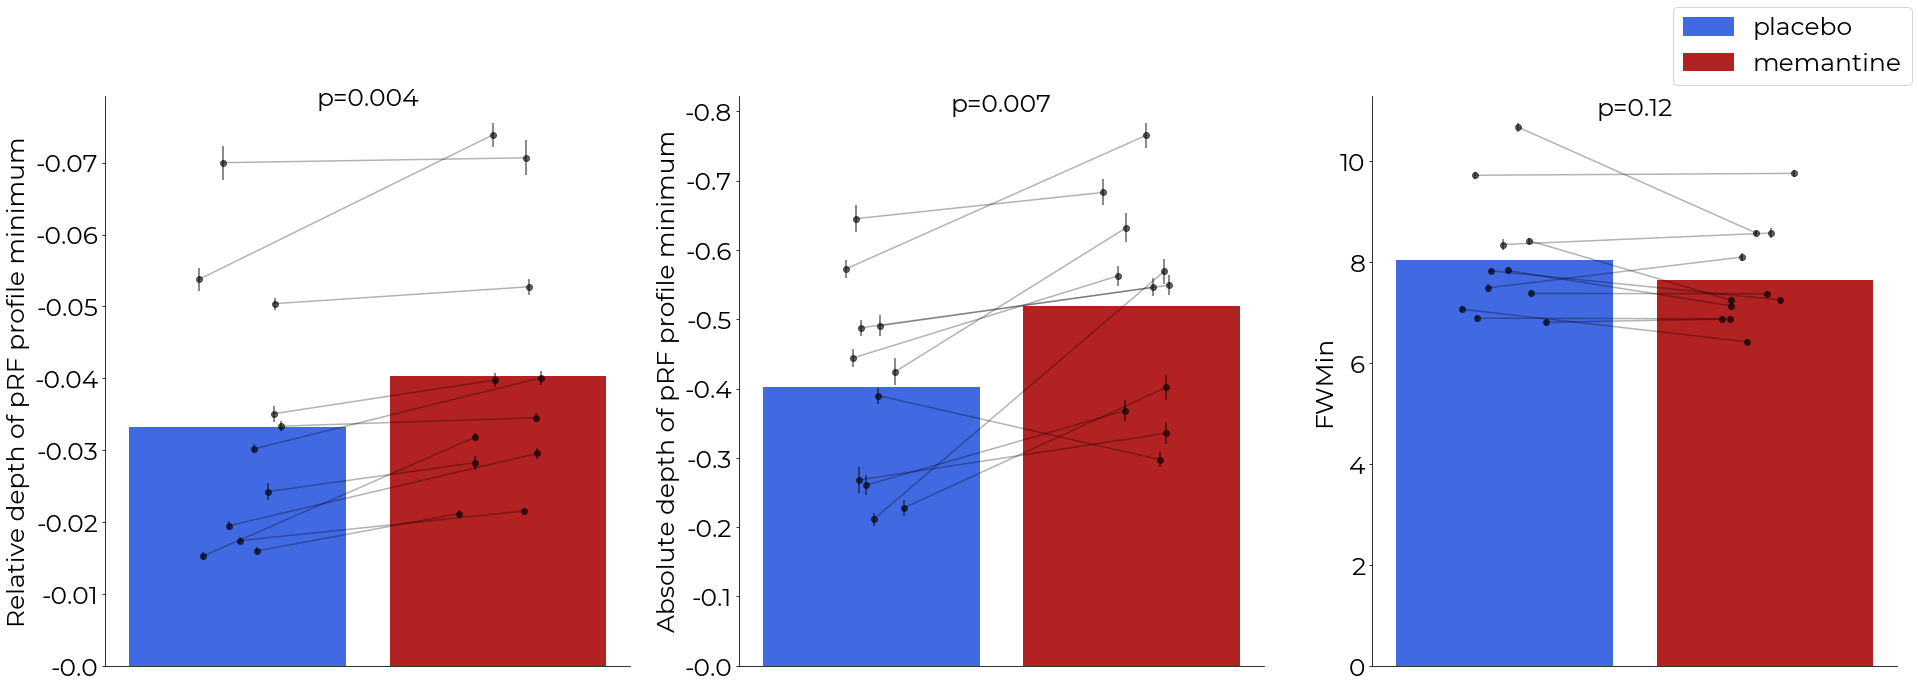

In [67]:
fig, axes = plt.subplots(1,3, figsize=(27, 9))
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 25})

params_title = {'min/max': 'Relative depth of pRF profile minimum', 'fwmin':'FWMin', 'minimum':'Absolute depth of pRF profile minimum'}

for k,metric in enumerate(['min/max','minimum', 'fwmin']):
    ax = axes[k%3]

    if metric in ['min/max','minimum']:
        i = -1
    else:
        i = 1
    
    param_means = {condition: [meandict_params[sub][condition][metric]['mean'] for sub in newsubs] for condition in ['placebo','memantine']}

    ax.bar(0.1, i*np.array(param_means['placebo']).mean(), width=0.1, color='royalblue')
    ax.bar(0.22, i*np.array(param_means['memantine']).mean(), width=0.1, color='firebrick')

    for sub in newsubs:   
        # FIRST PLOT MEANS, THEN CONNECT THEM
        plac_value = (0.1 + random.uniform(-0.02, 0.02), i*meandict_params[sub]['placebo'][metric]['mean'])
        mem_value = (0.22 + random.uniform(-0.02, 0.02), i*meandict_params[sub]['memantine'][metric]['mean'])

        ax.scatter(plac_value[0], plac_value[1], color='black', alpha=0.6)
        ax.scatter(mem_value[0], mem_value[1], color='black', alpha=0.6)

        #Plot line between points
        ax.plot([plac_value[0], mem_value[0]], [plac_value[1], mem_value[1]], color='black', alpha=0.3)

        #Plot error bar for each point
        ax.vlines(plac_value[0],ymin=plac_value[1]-meandict_params[sub]['placebo'][metric]['sem'], ymax=plac_value[1]+meandict_params[sub]['placebo'][metric]['sem'], color='black', alpha=0.6)
        ax.vlines(mem_value[0],ymin=mem_value[1]-meandict_params[sub]['memantine'][metric]['sem'], ymax=mem_value[1]+meandict_params[sub]['memantine'][metric]['sem'], color='black', alpha=0.6)

    ax.set_ylabel(f'{params_title[metric]}', fontsize=25)
    ax.set_xticks([])

    if k == 0:
        ax.set_yticklabels(['-' + str(round(tick,2)) for tick in ax.get_yticks()])
        ax.text(0.16, 0.078,f'p=0.004', horizontalalignment='center')
    elif k == 1:
        ax.set_yticklabels(['-' + str(round(tick,1)) for tick in ax.get_yticks()])
        ax.text(0.16, 0.8,f'p=0.007', horizontalalignment='center')
    else:
        ax.text(0.16, 10.9,f'p=0.12', horizontalalignment='center')

sns.despine()
fig.legend(handles=[placebo_patch, memantine_patch], loc='upper right', ncol=1, fontsize=25, bbox_to_anchor=[0, 0, 1, 1.1])
fig.tight_layout()

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/V1_surroundsuppression_supplement.png"

plt.savefig(save_path, bbox_inches='tight', dpi=300)

fig.show()

Now, the per-subject plots. First, eccentricity vs min/max

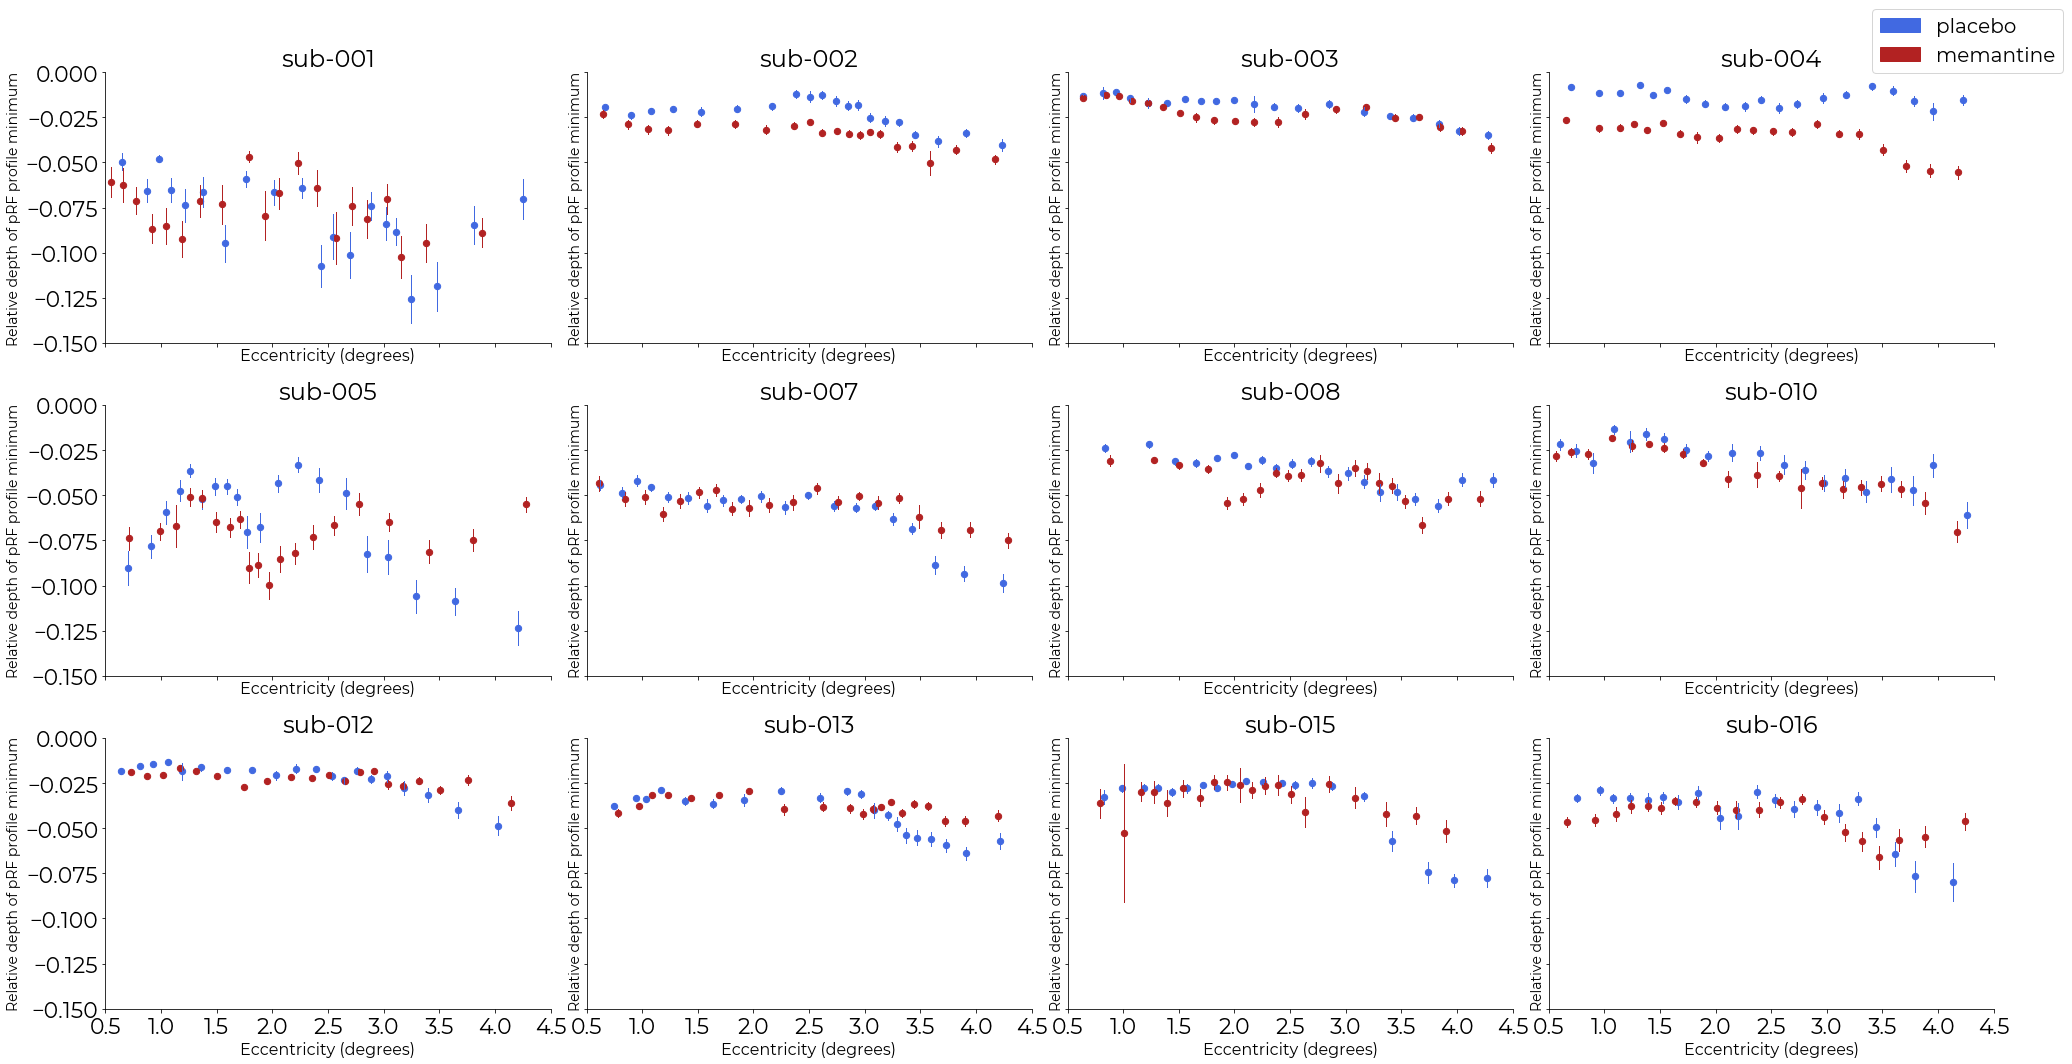

In [30]:
fig, axes = plt.subplots(3,4, figsize=(29, 15), sharey='row',sharex='col')
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 18})

for i, sub in enumerate(meandict.keys()):
    for condition in ['placebo','memantine']:
        ax = axes[i//4, i%4]

        ax.scatter(meandict[sub][condition]['scatter']['mean_ecc'], meandict[sub][condition]['scatter']['mean_metric'], color=colorlist[condition], s=40)
        
        for x, y, sem in zip(meandict[sub][condition]['scatter']['mean_ecc'], meandict[sub][condition]['scatter']['mean_metric'], meandict[sub][condition]['scatter']['sem_metric']):
            ax.plot([x, x], [y - sem, y + sem], color=colorlist[condition], linewidth=1)
        
        ax.set_title(sub, fontsize=24)
        ax.set_xlim([0.5,4.5])
        ax.set_ylim([-0.15,0])
        ax.set_xlabel('Eccentricity (degrees)', fontsize=16)
        ax.set_ylabel('Relative depth of pRF profile minimum', fontsize=14)
        sns.despine(ax=ax)

fig.legend(handles=[placebo_patch, memantine_patch], loc='upper right', ncol=1, fontsize=20)
fig.tight_layout(h_pad=1,w_pad=1, rect=[0,0,0.97,0.97])

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/V1_relativeminimum_scatter_subject.png"

plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()


Now, average pRF profile plots

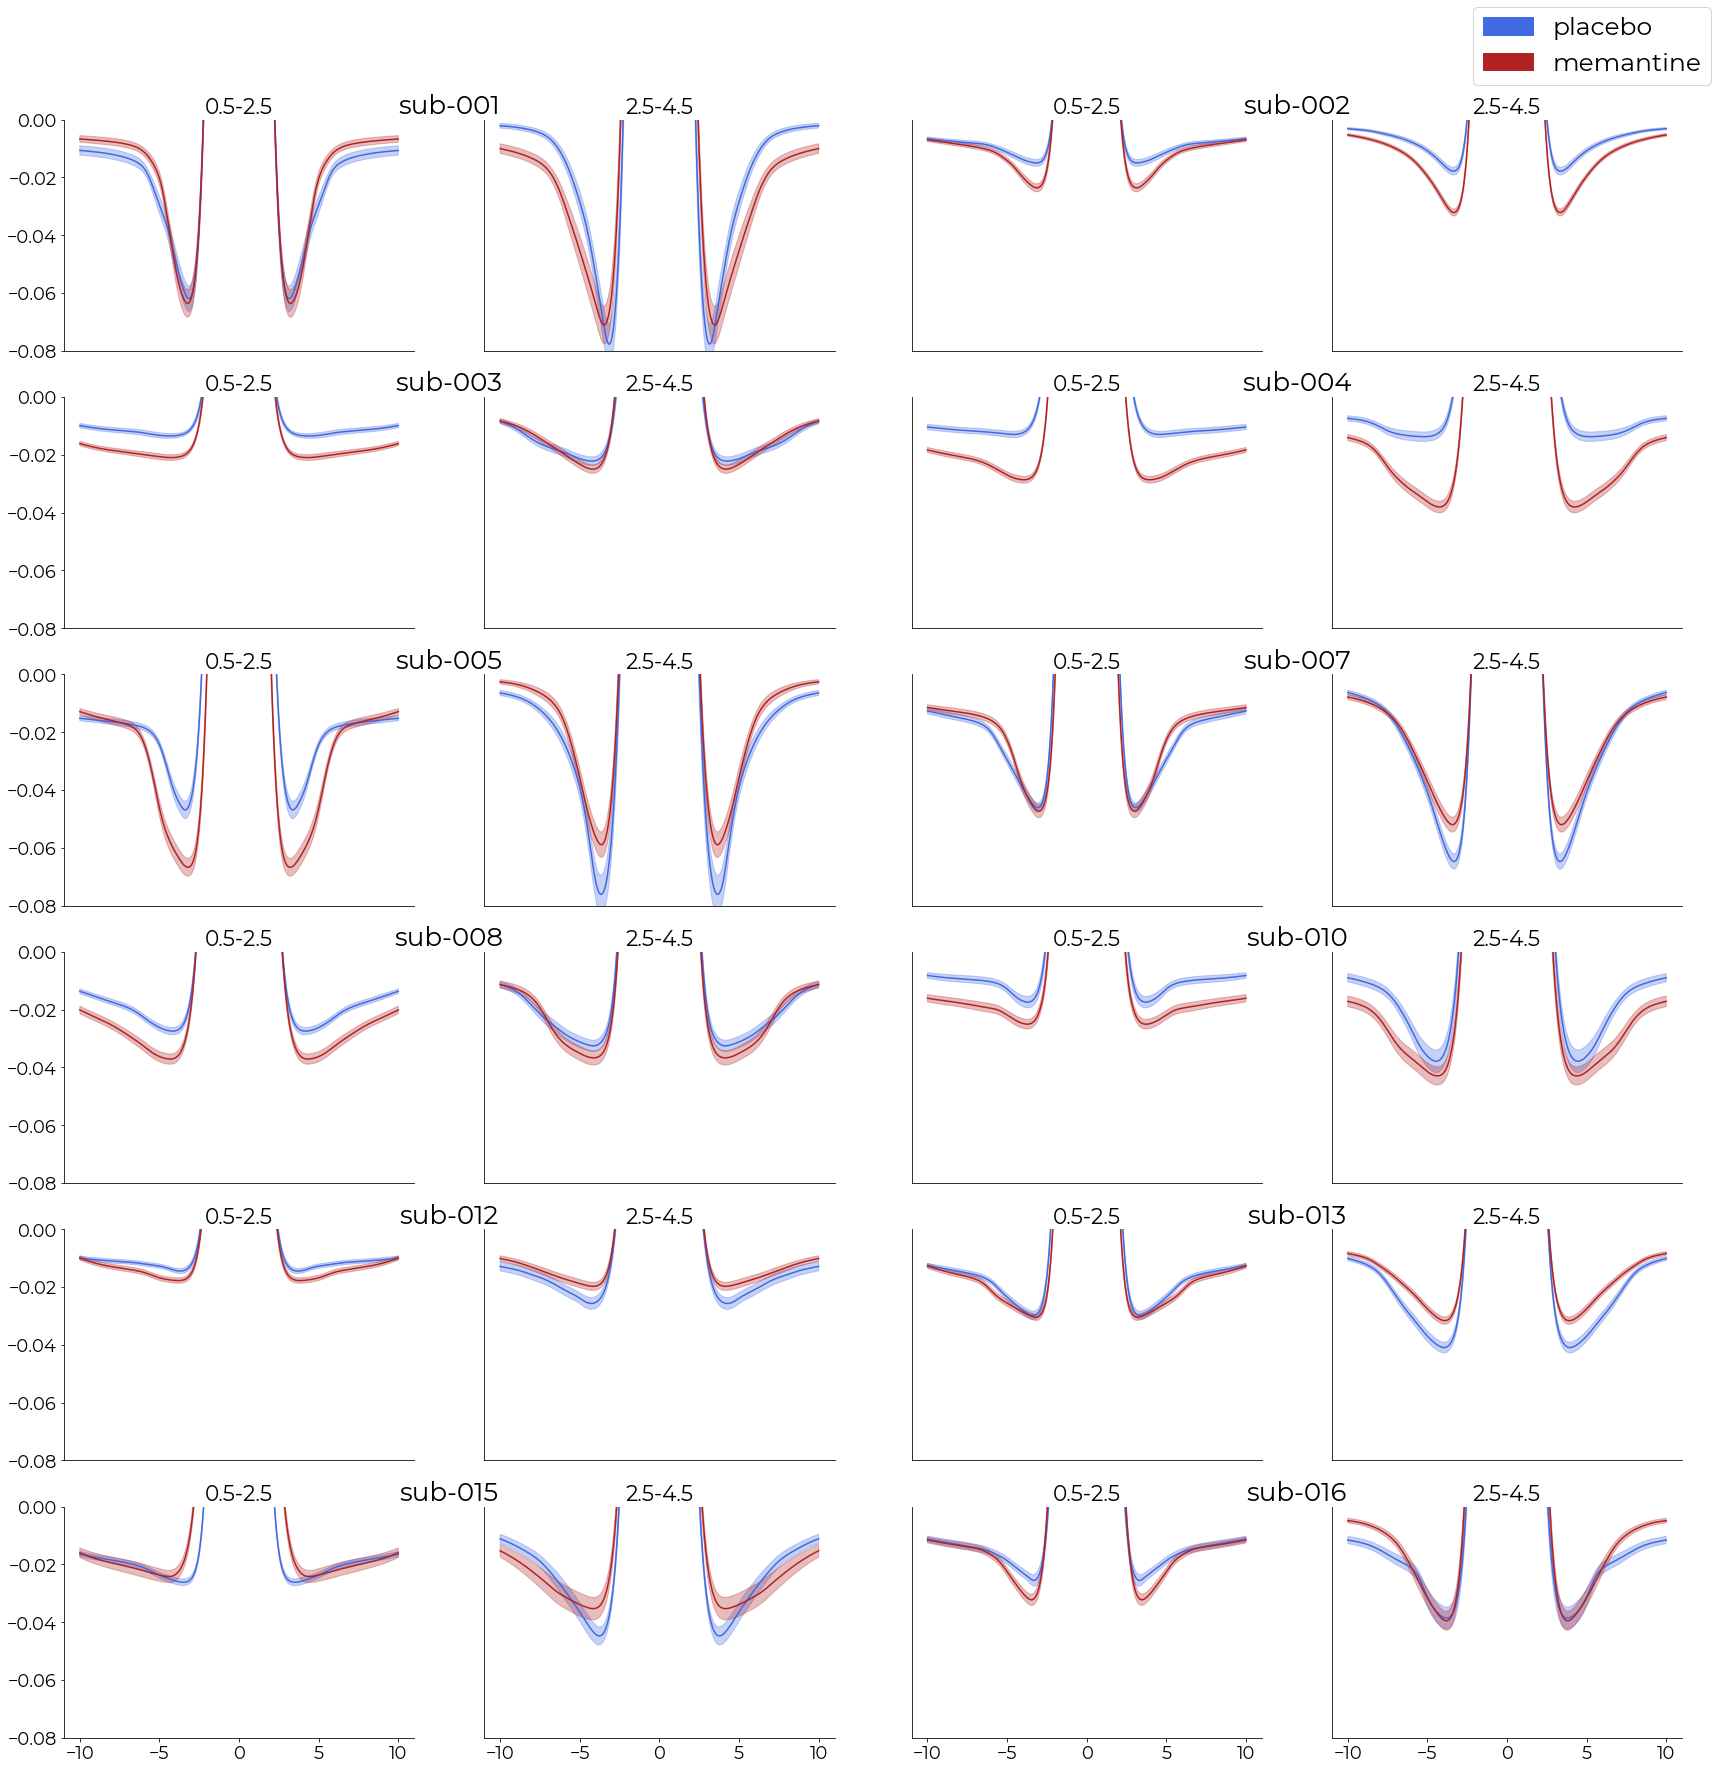

In [32]:
# Create a figure with a 6x2 grid layout
fig = plt.figure(figsize=(29, 29), constrained_layout=True)
fig.subplots_adjust(top=0.90)

outer_grid = gridspec.GridSpec(6, 2, hspace=0.2, wspace=0.1)

for index, sub in enumerate(meandict.keys()):
    row = index//2
    col = index%2

    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[row, col])

    for jndex, ecc in enumerate(['0.5-2.5','2.5-4.5']):
        ax = fig.add_subplot(inner_grid[jndex])

        for condition in ['placebo','memantine']:
            mean = meandict[sub][condition]['profile']['mean'][ecc]
            ci = meandict[sub][condition]['profile']['ci'][ecc]

            ax.plot(np.linspace(-10,10,2000), mean, color=colorlist[condition])
            ax.fill_between(np.linspace(-10,10,2000), mean-ci, mean+ci, color=colorlist[condition], alpha=0.3)

        if col != 0 or jndex != 0:
            ax.set_yticks([])
        
        if row != 5:
            ax.set_xticks([])

        ax.set_title(ecc)
        ax.set_ylim(-0.08,0)
        sns.despine(ax=ax)

    
    shared_title_ax = fig.add_subplot(outer_grid[row, col])
    shared_title_ax.set_frame_on(False)
    shared_title_ax.set_xticks([])
    shared_title_ax.set_yticks([])
    shared_title_ax.set_title(sub, fontsize=26, position=(0.5, -0.5))

fig.legend(handles=[placebo_patch, memantine_patch], ncol=1, fontsize=25, bbox_to_anchor=(0.92,0.96))
fig.tight_layout()

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/V1_pRFprofiles_subject.png"

plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

<h2>2. Effect of memantine on temporal responses to visual stimuli in V1 (only low eccentricity)</h2>

In [35]:
# necessary to calculate predicted time course

from prfpy.model import Model
xx = Model(prf_stim)

In [34]:
def timecourse_at_zero(pRFmodelFitting, params):
    #function to return the predicted time course

    prediction = pRFmodelFitting.norm_model.return_prediction(*np.concatenate([np.array([0,0]), params[2:-1]]))
    return prediction

In [36]:
def align_barpasses(prf_stim,prf_pos,timecourses_toalign):
    #function to return the measured BOLD response to the first bar sweep, shifted horizontally such that peaks overlap. Taken from M. Aqil's prfpytools

    #there needs to be a minus sign here for prfpy conventions
    y_ravel = -prf_stim.y_coordinates.reshape((-1))
    x_ravel = prf_stim.x_coordinates.reshape((-1))
    coords = np.array([x_ravel,y_ravel]).T

    bar_coms = []
    for time in range(prf_stim.design_matrix.shape[-1]):
        if prf_stim.design_matrix[:,:,time].sum()>0:
            dm_ravel = prf_stim.design_matrix[:,:,time].reshape((-1))
            com = np.average(coords, axis=0, weights=dm_ravel)
            bar_coms.append(com)
        else:
            bar_coms.append([np.nan,np.nan])
    bar_coms = np.array(bar_coms)

    dist_prf_bar = np.linalg.norm(bar_coms - prf_pos[np.newaxis,...],axis=1)

    bar_passes = [np.arange(15,35)]
    
    mindist = []

    for bp in bar_passes:
        this_bp_dist = dist_prf_bar[bp]
        mindist_bp = bp[np.nanargmin(this_bp_dist)]
        mindist.append(int(mindist_bp))

    timecourses_aligned = {}
    timecourses_tps = {}

    for tc_toalign in timecourses_toalign:
        centered_y = []
        centered_x = []
        for en,bp in enumerate(bar_passes):

            centered_x.append(bar_passes[en]-mindist[en])
            centered_y.append(timecourses_toalign[tc_toalign][bp])  
            
        centered_x = np.array(centered_x)
        centered_y = np.array(centered_y)
        centered_mean_x = []
        centered_mean_y = []
        for i in np.arange(np.min(centered_x),np.max(centered_x)):
            centered_mean_x.append(i)
            centered_mean_y.append(np.nanmean(centered_y[centered_x==i]))

        timecourses_tps[tc_toalign] = centered_mean_x
        timecourses_aligned[tc_toalign] = centered_mean_y

    return timecourses_tps,timecourses_aligned

Now, calculate the average predicted time course and measured BOLD time course in low-eccentricity vertices in V1, for each subject and condition

In [37]:
meandict_temporal = {sub:{condition:{'prediction':{}, 'bold': {}, 'hrf': {}} for condition in ['placebo','memantine']} for sub in conditions.keys()}

# Add subplots to the nested GridSpec
for index, sub in enumerate(meandict_temporal.keys()):
    print("working on",  sub)

    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>0.3 or 
                                prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>0.3)]

    for i, condition in enumerate(['placebo', 'memantine']):
        models = deepcopy(prffits[sub]['fits'][condition].pRFmodelFitting)
        models.norm_model.stimulus = prf_stim
        params_valid = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared]

        print(params_valid.shape)
        valid_vertices_V1_shared_lowecc = params_valid[(params_valid['ecc']>0.5) & (params_valid['ecc']<2.5)].index

        params_valid_lowecc = models.norm_iter[valid_vertices_V1_shared_lowecc,...]        

        #################### FIRST, CALCULATE PREDICTED TIME COURSES ###############
        #calculate average time courses
        timecourses = np.array([timecourse_at_zero(models, row) for row in params_valid_lowecc])
            
        # Convert the list of profiles to a 2D NumPy array
        timecourses_array = timecourses.reshape(timecourses.shape[0],35)        
        print(timecourses_array.shape)

        mean, std, sem, ci = get_mean_profile(timecourses_array, weighted=True, weights=params_valid_lowecc[:,-1])
        meandict_temporal[sub][condition]['prediction']['mean']= mean
        meandict_temporal[sub][condition]['prediction']['ci']= ci

        #################### NEXT, CALCULATE THE ACTUAL BAR PASSES ################
        timecourses_all = {}

        for vertex in valid_vertices_V1_shared_lowecc:
            bold_array = models.data[vertex,...]
            prf_pos = params_valid.loc[vertex][['x','y']]

            timecourses_tps, timecourses_aligned = align_barpasses(prf_stim2, prf_pos, pd.DataFrame(bold_array))

            current_length = len(timecourses_tps[0])
            total_padding = 38 - current_length
            pad_each_side = total_padding // 2 
            padded_vertex = [np.nan] * pad_each_side + list(timecourses_aligned[0]) + [np.nan] * (total_padding - pad_each_side)

            timecourses_all[vertex] = padded_vertex
        
        timecourses_all = pd.DataFrame.from_dict(timecourses_all, orient='index', columns=range(-19,19))

        mean = np.ma.average(np.ma.array(timecourses_all.values, mask=timecourses_all.isnull().values), weights=params_valid_lowecc[:,-1], axis=0)
        std = np.ma.std(np.ma.array(timecourses_all.values, mask=timecourses_all.isnull().values), axis=0)
        sem = std/np.sqrt(len(timecourses_all))
        ci = 1.96*sem

        meandict_temporal[sub][condition]['bold']['mean']= mean
        meandict_temporal[sub][condition]['bold']['ci']= ci

        #################### LASTLY, CALCULATE HRF ##########################

        hrfs = np.vstack([xx.create_hrf([1, row[-3], 0]) for row in params_valid_lowecc])
        print(hrfs.shape)

        mean, std, sem, ci = get_mean_profile(hrfs, weighted=True, weights=params_valid_lowecc[:,-1])
        meandict_temporal[sub][condition]['hrf']['mean']= mean
        meandict_temporal[sub][condition]['hrf']['ci']= ci

working on sub-001
(1060, 28)
(586, 35)
(586, 27)
(1060, 28)
(695, 35)
(695, 27)
working on sub-002
(2553, 28)
(1071, 35)
(1071, 27)
(2553, 28)
(1067, 35)
(1067, 27)
working on sub-003
(2640, 28)
(1605, 35)
(1605, 27)
(2640, 28)
(1569, 35)
(1569, 27)
working on sub-004
(2205, 28)
(1193, 35)
(1193, 27)
(2205, 28)
(1252, 35)
(1252, 27)
working on sub-005
(1945, 28)
(1331, 35)
(1331, 27)
(1945, 28)
(1363, 35)
(1363, 27)
working on sub-007
(2370, 28)
(1368, 35)
(1368, 27)
(2370, 28)
(1319, 35)
(1319, 27)
working on sub-008
(2238, 28)
(1042, 35)
(1042, 27)
(2238, 28)
(973, 35)
(973, 27)
working on sub-010
(1033, 28)
(556, 35)
(556, 27)
(1033, 28)
(548, 35)
(548, 27)
working on sub-012
(2193, 28)
(1230, 35)
(1230, 27)
(2193, 28)
(1133, 35)
(1133, 27)
working on sub-013
(3090, 28)
(1258, 35)
(1258, 27)
(3090, 28)
(1241, 35)
(1241, 27)
working on sub-015
(1446, 28)
(872, 35)
(872, 27)
(1446, 28)
(979, 35)
(979, 27)
working on sub-016
(2034, 28)
(1139, 35)
(1139, 27)
(2034, 28)
(1115, 35)
(1115

Now, plot for all subjects together

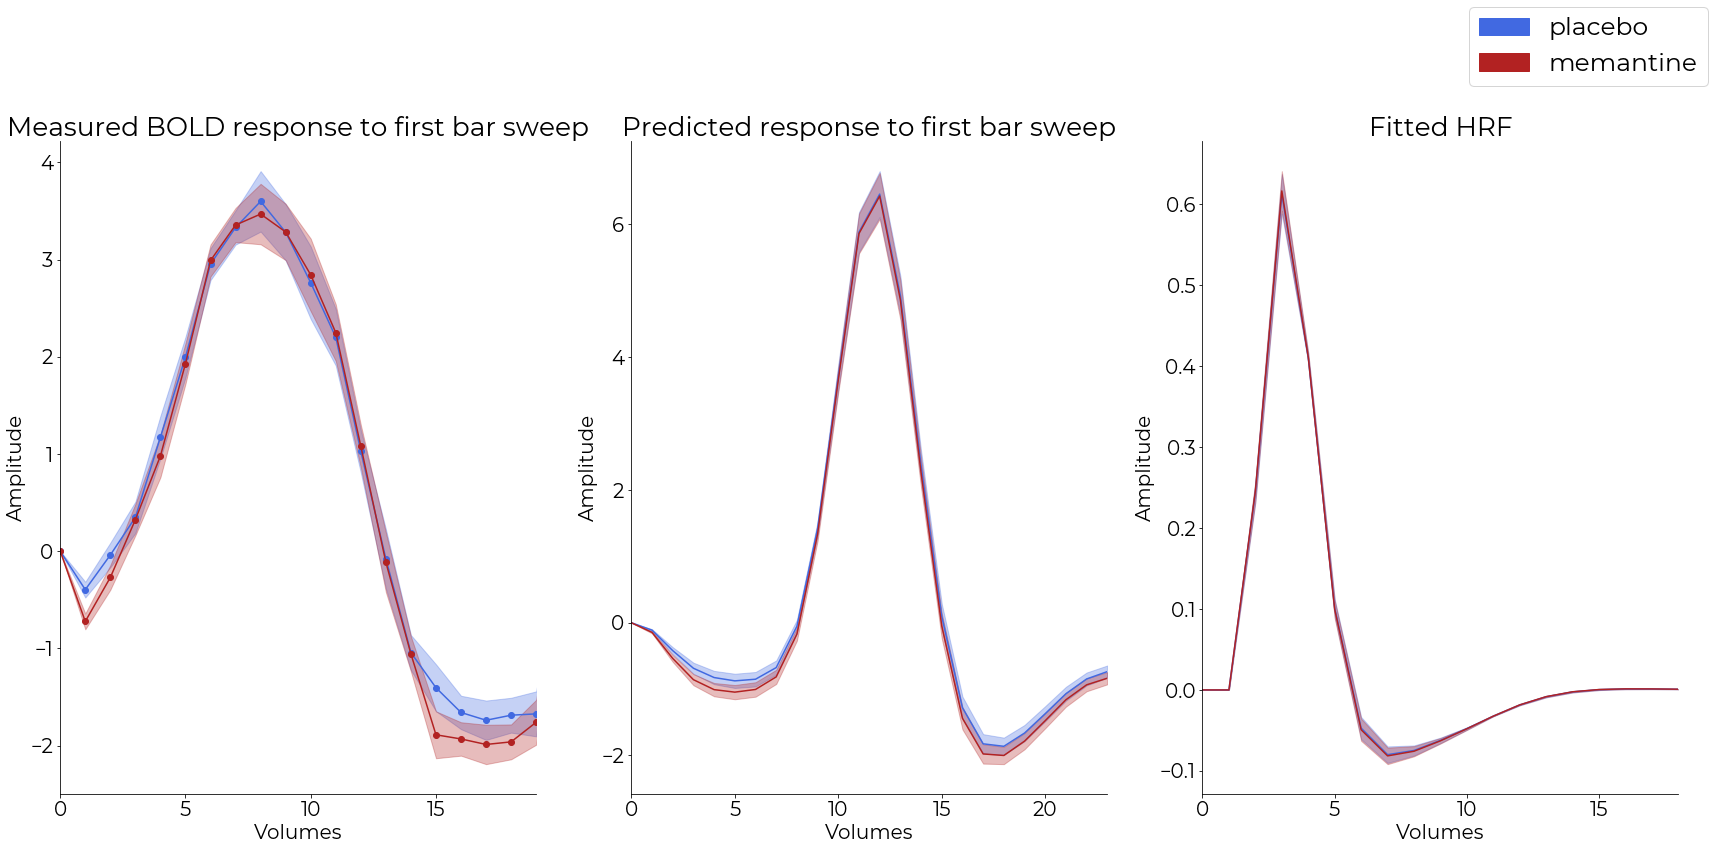

In [42]:
fig, axes = plt.subplots(1,3, figsize=(29, 12))
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 22})

################# PANEL A: ACTUAL TIME COURSE ########################
subavgs = {sub: np.mean(np.vstack([meandict_temporal[sub][condition]['bold']['mean'] for condition in ['placebo','memantine']]), axis=0) for sub in meandict_temporal.keys()}
grandavg = np.mean(np.vstack([meandict_temporal[sub][condition]['bold']['mean'] for sub in meandict_temporal.keys() for condition in ['placebo','memantine']]), axis=0)

meandict_temporal_corrected = {sub: {condition: meandict_temporal[sub][condition]['bold']['mean']-subavgs[sub]+grandavg for condition in ['placebo','memantine']} for sub in meandict_temporal.keys()}

for index, condition in enumerate(['placebo', 'memantine']):
    mean_allsubs = np.mean(np.vstack([meandict_temporal[sub][condition]['bold']['mean'] for sub in meandict_temporal.keys()]), axis=0)

    sem_allsubs = np.std(np.vstack([meandict_temporal_corrected[sub][condition] for sub in meandict_temporal_corrected.keys()]), axis=0)/np.sqrt(12)

    ci_allsubs = 1.96*sem_allsubs

    axes[0].plot(mean_allsubs, color = colorlist[condition], marker='o')
    axes[0].fill_between(range(38), mean_allsubs-ci_allsubs, mean_allsubs+ci_allsubs, color = colorlist[condition], alpha=0.3)

axes[0].set_xlim(8,27)
axes[0].set_title("Measured BOLD response to first bar sweep")
axes[0].set_ylabel("Amplitude")
axes[0].set_xlabel("Volumes")
axes[0].set_xticks(range(8,27,5), range(0,19,5))


################# PANEL B: PREDICTED TIME COURSE ########################
subavgs = {sub: np.mean(np.vstack([meandict_temporal[sub][condition]['prediction']['mean'] for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
grandavg = np.mean(np.vstack([meandict_temporal[sub][condition]['prediction']['mean'] for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

meandict_temporal_corrected = {sub: {condition: meandict_temporal[sub][condition]['prediction']['mean']-subavgs[sub]+grandavg for condition in ['placebo','memantine']} for sub in newsubs}

for index, condition in enumerate(['placebo', 'memantine']):
    mean_allsubs = np.mean(np.vstack([meandict_temporal[sub][condition]['prediction']['mean'] for sub in newsubs]), axis=0)

    sem_allsubs = np.std(np.vstack([meandict_temporal_corrected[sub][condition] for sub in newsubs]), axis=0)/np.sqrt(11)

    ci_allsubs = 1.96*sem_allsubs

    axes[1].plot(mean_allsubs, color = colorlist[condition])
    axes[1].fill_between(range(35), mean_allsubs-ci_allsubs, mean_allsubs+ci_allsubs, color = colorlist[condition], alpha=0.3)

axes[1].set_xlim(11,34)
axes[1].set_title("Predicted response to first bar sweep")
axes[1].set_ylabel("Amplitude")
axes[1].set_xlabel("Volumes")
axes[1].set_xticks(range(11,34,5), range(0,23,5))


################# PANEL C: HRF ########################
subavgs = {sub: np.mean(np.vstack([meandict_temporal[sub][condition]['hrf']['mean'] for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
grandavg = np.mean(np.vstack([meandict_temporal[sub][condition]['hrf']['mean'] for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

meandict_temporal_corrected = {sub: {condition: meandict_temporal[sub][condition]['hrf']['mean']-subavgs[sub]+grandavg for condition in ['placebo','memantine']} for sub in newsubs}

for index, condition in enumerate(['placebo', 'memantine']):
    mean_allsubs = np.mean(np.vstack([meandict_temporal[sub][condition]['hrf']['mean'] for sub in newsubs]), axis=0)

    sem_allsubs = np.std(np.vstack([meandict_temporal_corrected[sub][condition] for sub in newsubs]), axis=0)/np.sqrt(11)

    ci_allsubs = 1.96*sem_allsubs

    axes[2].plot(range(27),mean_allsubs, color = colorlist[condition])
    axes[2].fill_between(range(27), mean_allsubs-ci_allsubs, mean_allsubs+ci_allsubs, color = colorlist[condition], alpha=0.3)

axes[2].set_xlim(0,18)
axes[2].set_title("Fitted HRF")
axes[2].set_ylabel("Amplitude")
axes[2].set_xlabel("Volumes")


fig.legend(handles=[placebo_patch, memantine_patch], ncol=1, fontsize=25, bbox_to_anchor=(0.92,1.05))

sns.despine()

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/V1_temporalsuppression.png"

plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

Test the one point that differs between the two conditions:

In [43]:
mean_bold_allsubs_placebo_9 = np.array([meandict_temporal[sub]['placebo']['bold']['mean'][9] for sub in newsubs])
mean_bold_allsubs_memantine_9 = np.array([meandict_temporal[sub]['memantine']['bold']['mean'][9] for sub in newsubs])

mean_bold_allsubs_placebo_23 = np.array([meandict_temporal[sub]['placebo']['bold']['mean'][23] for sub in newsubs])
mean_bold_allsubs_memantine_23 = np.array([meandict_temporal[sub]['memantine']['bold']['mean'][23] for sub in newsubs])

In [44]:
print("Paired t-test for point 9:", ttest_rel(mean_bold_allsubs_placebo_9, mean_bold_allsubs_memantine_9))
print("Paired t-test for point 23:", ttest_rel(mean_bold_allsubs_placebo_23, mean_bold_allsubs_memantine_23))

Paired t-test for point 9: Ttest_relResult(statistic=3.355569043002686, pvalue=0.007296565699381439)
Paired t-test for point 23: Ttest_relResult(statistic=1.8477531555895952, pvalue=0.09439211688765607)


Now, plot per subject:

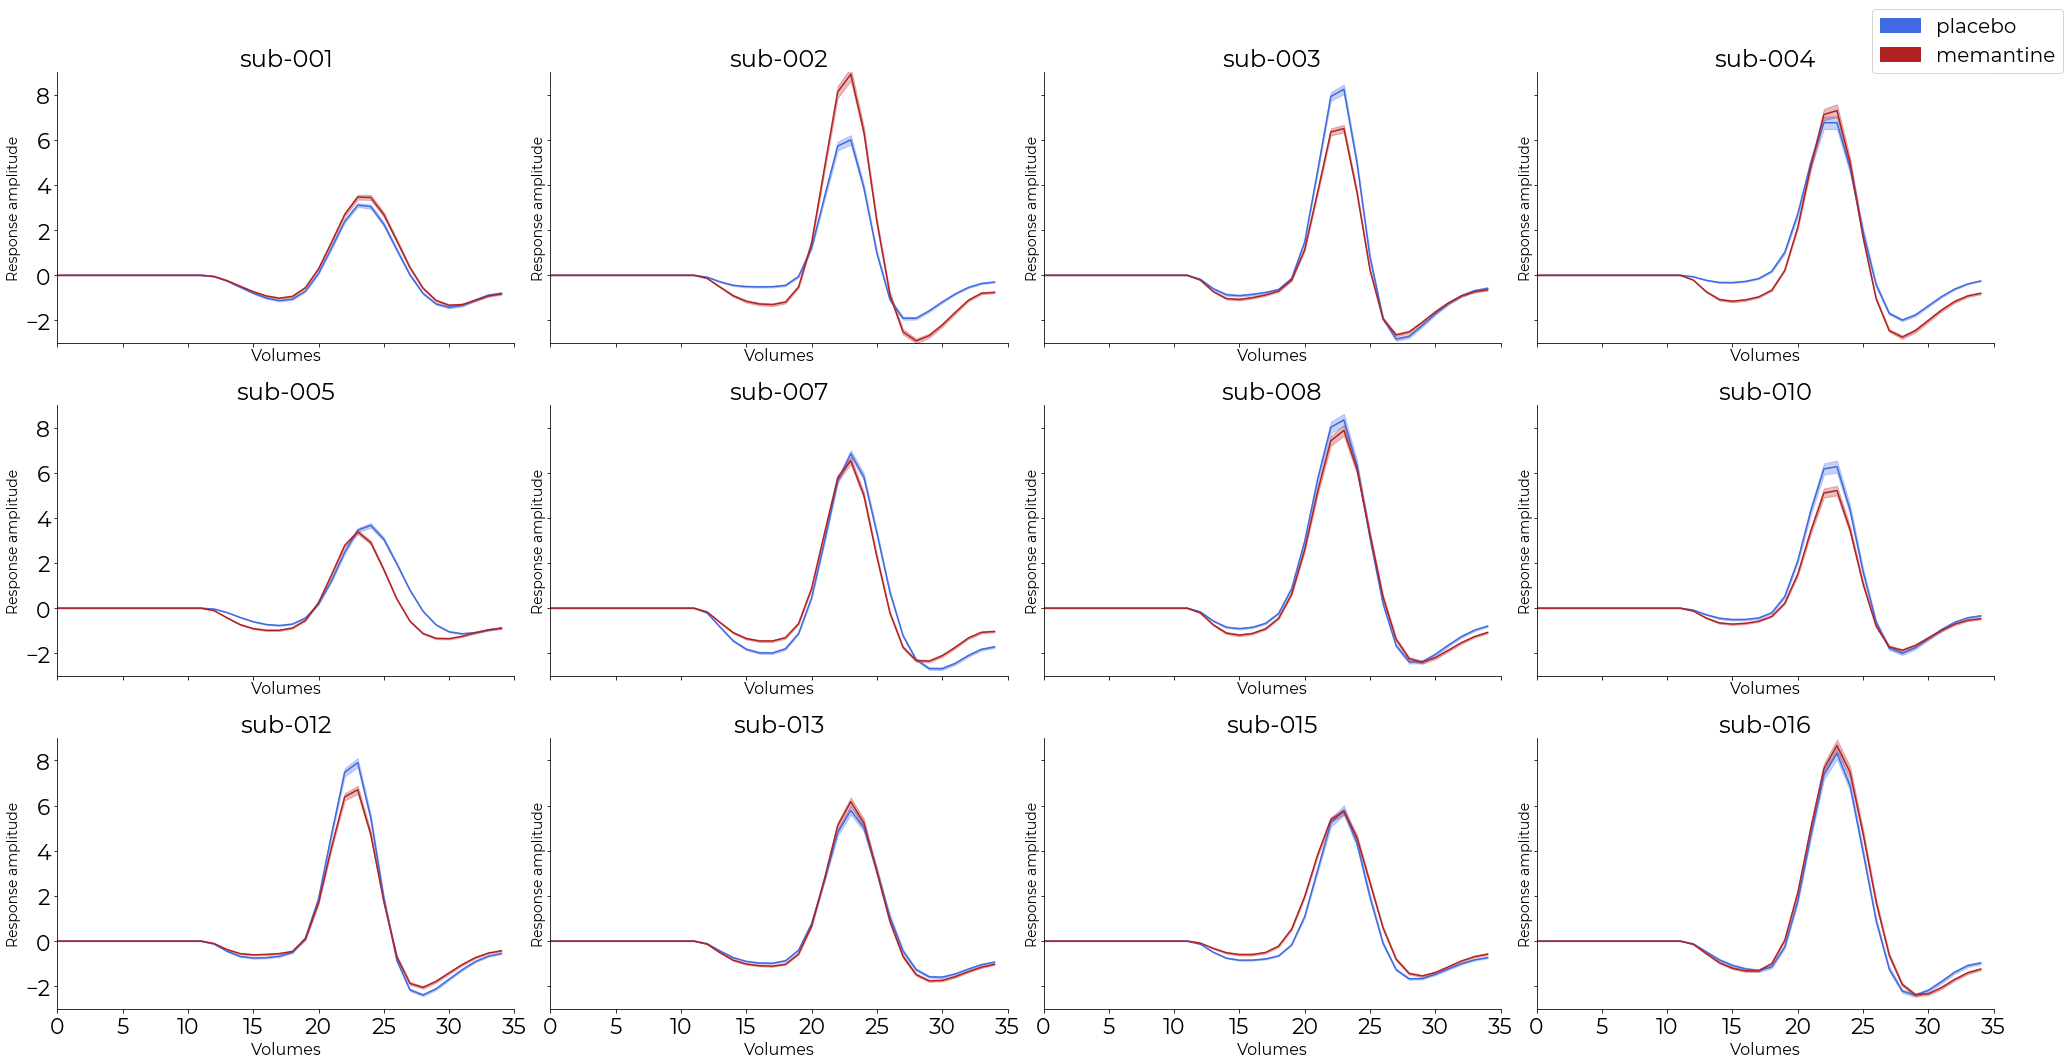

In [45]:
fig, axes = plt.subplots(3,4, figsize=(29, 15), sharey='row',sharex='col')
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 18})

for i, sub in enumerate(meandict.keys()):
    for condition in ['placebo','memantine']:
        ax = axes[i//4, i%4]
        
        mean = meandict_temporal[sub][condition]['prediction']['mean'] 
        ci = meandict_temporal[sub][condition]['prediction']['ci']

        ax.plot(mean, color=colorlist[condition])
        ax.fill_between(range(0,35), mean-ci, mean+ci, color=colorlist[condition],alpha=0.3)
        
        ax.set_title(sub, fontsize=24)
        ax.set_xlim([0,35])
        ax.set_ylim([-3,9])
        ax.set_xlabel('Volumes', fontsize=16)
        ax.set_ylabel('Response amplitude', fontsize=14)
        sns.despine(ax=ax)

fig.legend(handles=[placebo_patch, memantine_patch], loc='upper right', ncol=1, fontsize=20)
fig.tight_layout(h_pad=1,w_pad=1, rect=[0,0,0.97,0.97])

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/V1_avgprediction_subject.png"

plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()


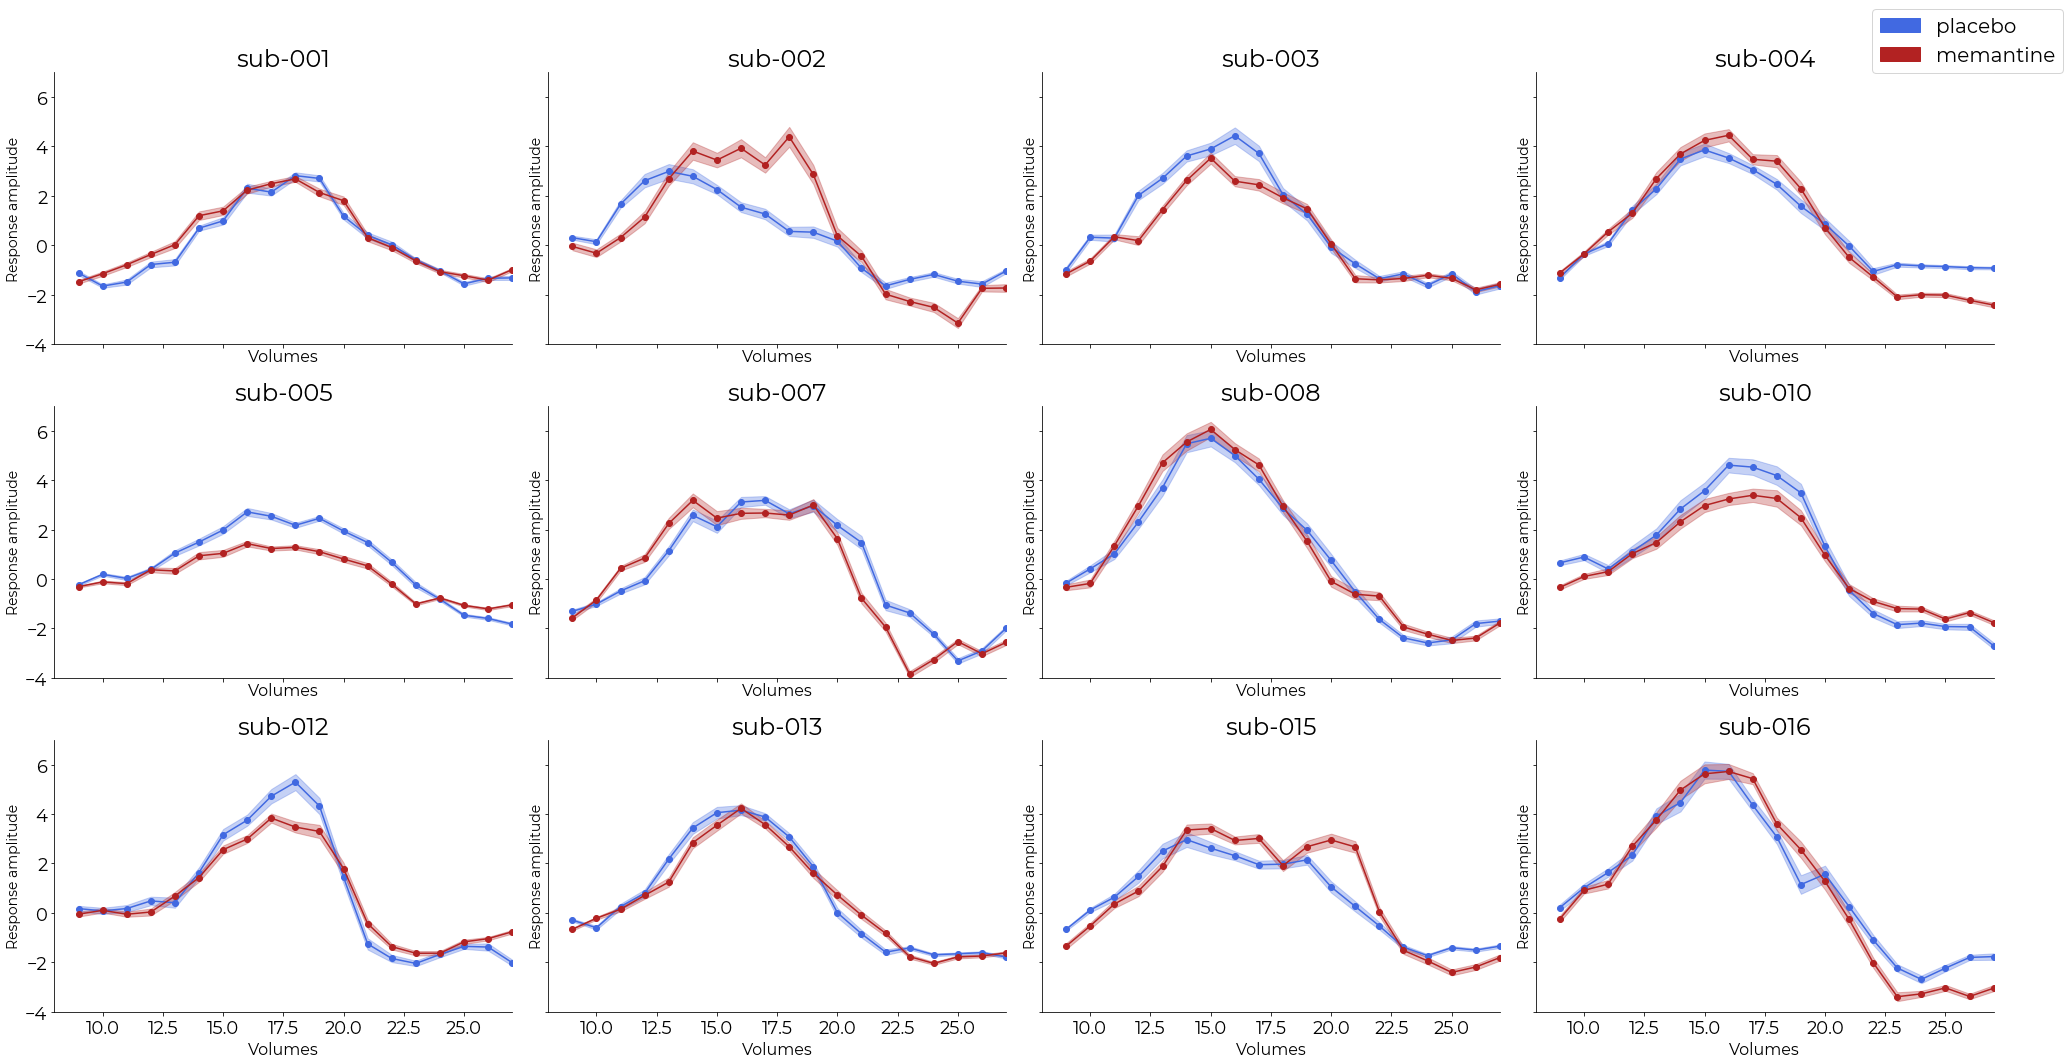

In [46]:
fig, axes = plt.subplots(3,4, figsize=(29, 15), sharey='row',sharex='col')
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 18})

for i, sub in enumerate(meandict.keys()):
    for condition in ['placebo','memantine']:
        ax = axes[i//4, i%4]
        
        mean = meandict_temporal[sub][condition]['bold']['mean'] 
        ci = meandict_temporal[sub][condition]['bold']['ci']

        ax.plot(mean, color=colorlist[condition], marker='o')
        ax.fill_between(range(0,38), mean-ci, mean+ci, color=colorlist[condition],alpha=0.3)
        
        ax.set_title(sub, fontsize=24)
        ax.set_xlim([8,27])
        ax.set_ylim([-4,7])
        ax.set_xlabel('Volumes', fontsize=16)
        ax.set_ylabel('Response amplitude', fontsize=14)
        sns.despine(ax=ax)

fig.legend(handles=[placebo_patch, memantine_patch], loc='upper right', ncol=1, fontsize=20)
fig.tight_layout(h_pad=1,w_pad=1, rect=[0,0,0.97,0.97])

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/V1_avgBOLD_subject.png"

plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()


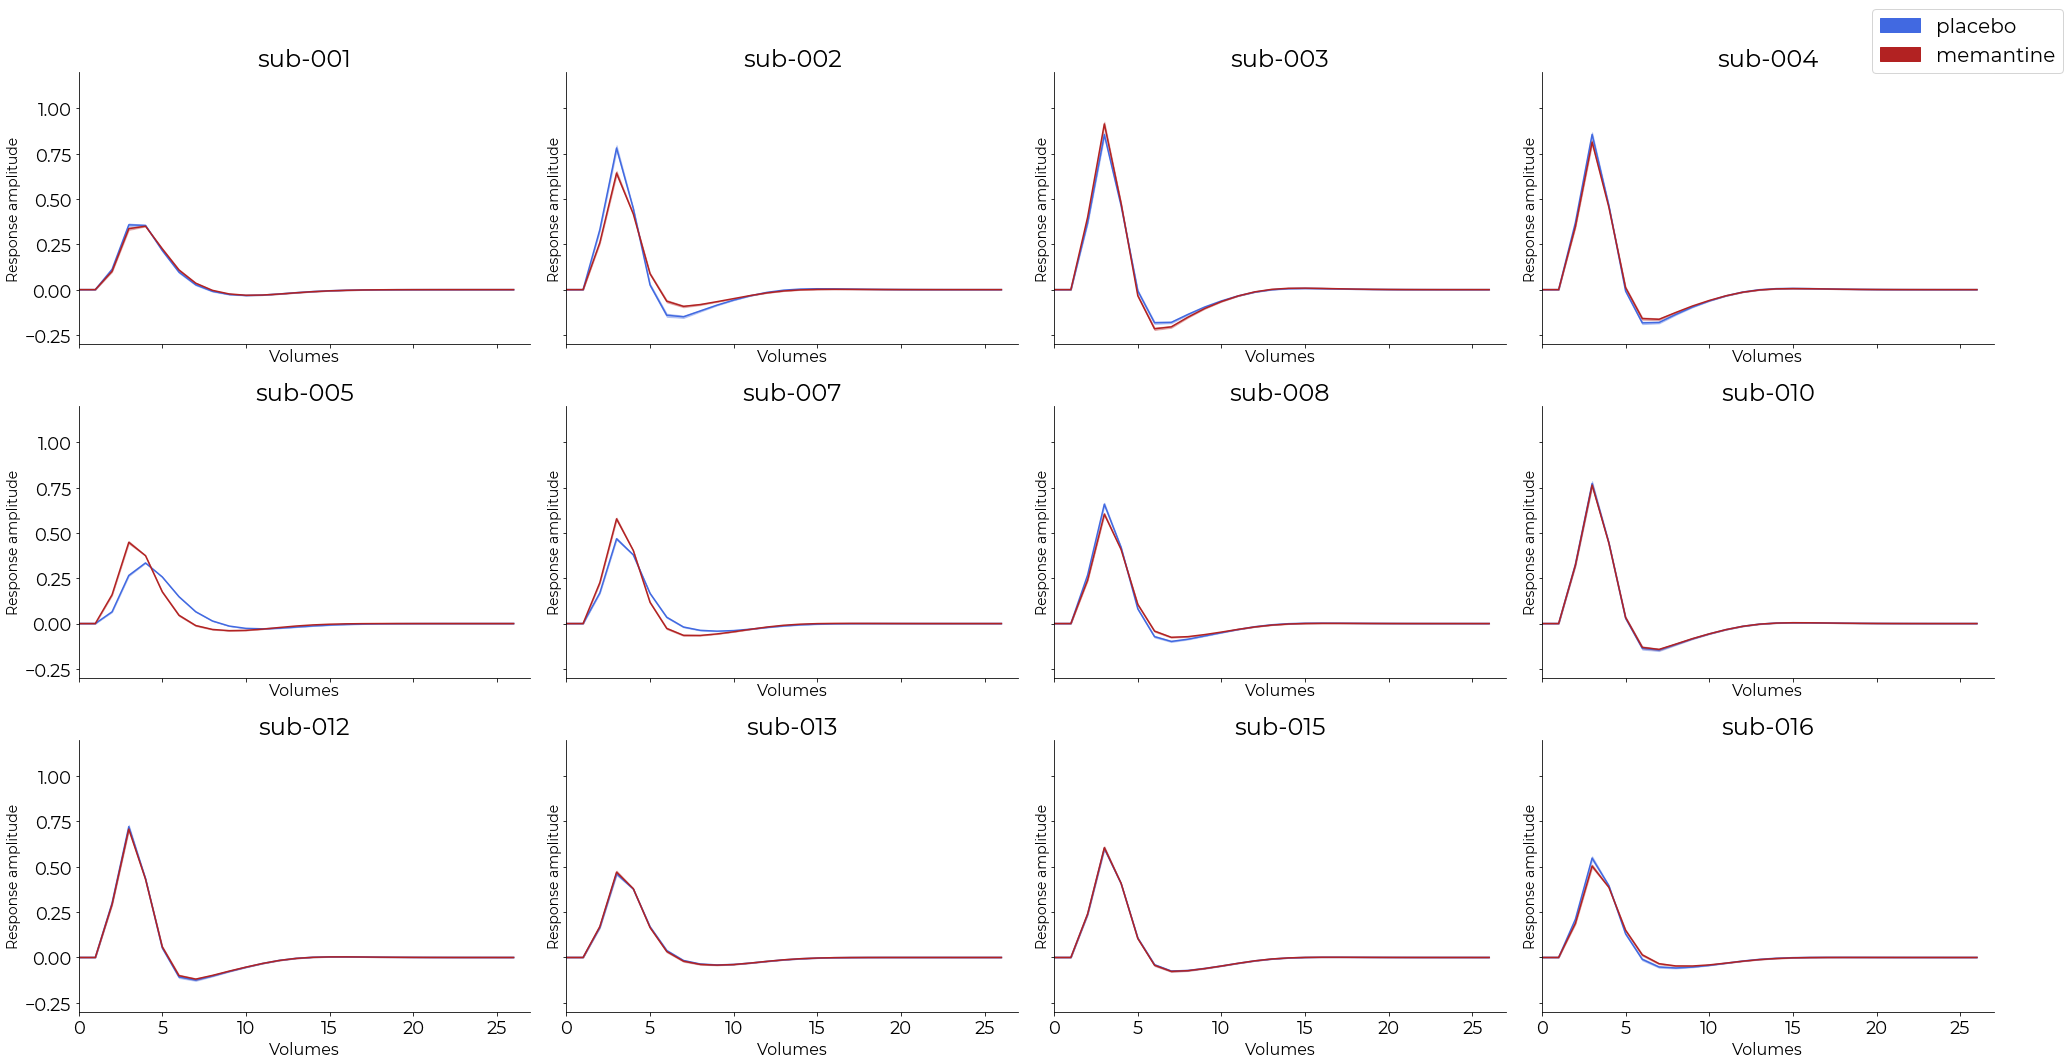

In [48]:
fig, axes = plt.subplots(3,4, figsize=(29, 15), sharey='row',sharex='col')
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 18})

for i, sub in enumerate(meandict.keys()):
    for condition in ['placebo','memantine']:
        ax = axes[i//4, i%4]
        
        mean = meandict_temporal[sub][condition]['hrf']['mean'] 
        ci = meandict_temporal[sub][condition]['hrf']['ci']

        ax.plot(mean, color=colorlist[condition])
        ax.fill_between(range(0,27), mean-ci, mean+ci, color=colorlist[condition],alpha=0.3)
        
        ax.set_title(sub, fontsize=24)
        ax.set_xlim([0,27])
        ax.set_ylim([-0.3,1.2])
        ax.set_xlabel('Volumes', fontsize=16)
        ax.set_ylabel('Response amplitude', fontsize=14)
        sns.despine(ax=ax)

fig.legend(handles=[placebo_patch, memantine_patch], loc='upper right', ncol=1, fontsize=20)
fig.tight_layout(h_pad=1,w_pad=1, rect=[0,0,0.97,0.97])

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/V1_relativeminimum_scatter_subject.pdf"

plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()


<h2>3. Effect of memantine on nonlinear spatial summation as measured with response curve r(s)</h2>

In [49]:
def get_response_curve(params):
    # function to calculate response curve
    
    s=np.linspace(0,1,1000)

    curve = (params['A']*s + params['B'])/(params['C']*s + params['D']) - (params['B']/params['D'])
    curve = curve/curve[-1]
    return curve

In [50]:
meandict_nonlinear = {sub:{condition:{} for condition in ['placebo','memantine']} for sub in conditions.keys()}

# Add subplots to the nested GridSpec
for index, sub in enumerate(meandict_nonlinear.keys()):
    print("working on",  sub)

    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>0.3 or 
                                prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>0.3)]

    for i, condition in enumerate(['placebo', 'memantine']):

        params_valid = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared]

        print(params_valid.shape)
        valid_vertices_V1_shared_lowecc = params_valid[(params_valid['ecc']>0.5) & (params_valid['ecc']<2.5)].index

        params_valid_lowecc = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared_lowecc]      

        #################### FIRST, CALCULATE PREDICTED TIME COURSES ###############
        #calculate average time courses
        responseprofiles = np.vstack(params_valid_lowecc.apply(get_response_curve, axis=1))
            
        # Convert the list of profiles to a 2D NumPy array
        print(responseprofiles.shape)

        mean, std, sem, ci = get_mean_profile(responseprofiles, weighted=True, weights=params_valid_lowecc['r2'])
        meandict_nonlinear[sub][condition]['mean']= mean
        meandict_nonlinear[sub][condition]['ci']= ci

working on sub-001
(1060, 28)
(586, 1000)
(1060, 28)
(695, 1000)
working on sub-002
(2553, 28)
(1071, 1000)
(2553, 28)
(1067, 1000)
working on sub-003
(2640, 28)
(1605, 1000)
(2640, 28)
(1569, 1000)
working on sub-004
(2205, 28)
(1193, 1000)
(2205, 28)
(1252, 1000)
working on sub-005
(1945, 28)
(1331, 1000)
(1945, 28)
(1363, 1000)
working on sub-007
(2370, 28)
(1368, 1000)
(2370, 28)
(1319, 1000)
working on sub-008
(2238, 28)
(1042, 1000)
(2238, 28)
(973, 1000)
working on sub-010
(1033, 28)
(556, 1000)
(1033, 28)
(548, 1000)
working on sub-012
(2193, 28)
(1230, 1000)
(2193, 28)
(1133, 1000)
working on sub-013
(3090, 28)
(1258, 1000)
(3090, 28)
(1241, 1000)
working on sub-015
(1446, 28)
(872, 1000)
(1446, 28)
(979, 1000)
working on sub-016
(2034, 28)
(1139, 1000)
(2034, 28)
(1115, 1000)


Now, plot mean for all subjects:

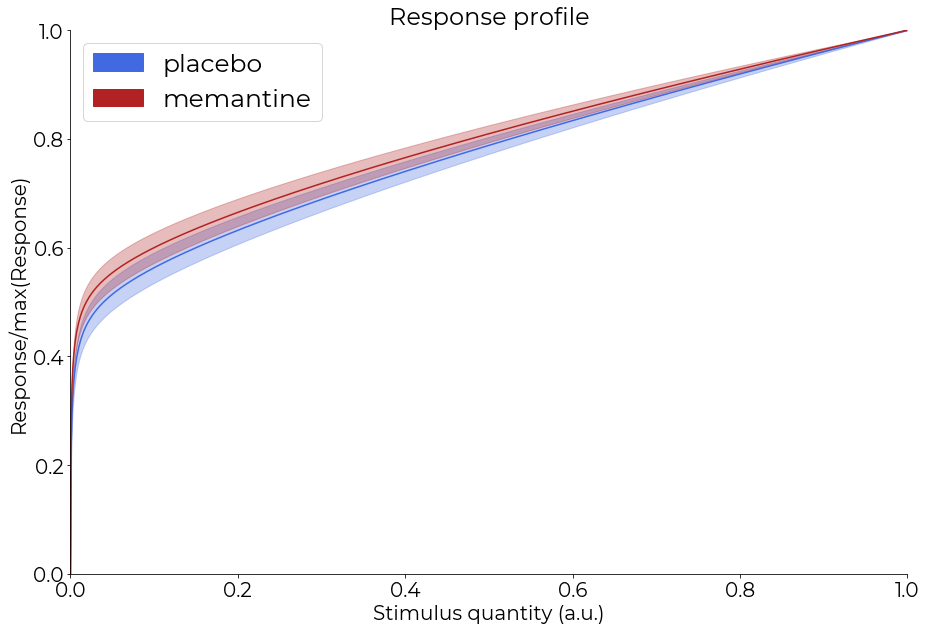

In [51]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 20})

################# PANEL A: ACTUAL TIME COURSE ########################
subavgs = {sub: np.mean(np.vstack([meandict_nonlinear[sub][condition]['mean'] for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
grandavg = np.mean(np.vstack([meandict_nonlinear[sub][condition]['mean'] for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

meandict_nonlinear_corrected = {sub: {condition: meandict_nonlinear[sub][condition]['mean']-subavgs[sub]+grandavg for condition in ['placebo','memantine']} for sub in newsubs}

for index, condition in enumerate(['placebo', 'memantine']):
    mean_allsubs = np.mean(np.vstack([meandict_nonlinear[sub][condition]['mean'] for sub in newsubs]), axis=0)

    sem_allsubs = np.std(np.vstack([meandict_nonlinear_corrected[sub][condition] for sub in newsubs]), axis=0)/np.sqrt(11)

    ci_allsubs = 1.96*sem_allsubs

    plt.plot(np.linspace(0,1,1000), mean_allsubs, color = colorlist[condition])
    plt.fill_between(np.linspace(0,1,1000), mean_allsubs-ci_allsubs, mean_allsubs+ci_allsubs, color = colorlist[condition], alpha=0.3)


plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Response profile")
plt.ylabel("Response/max(Response)")
plt.xlabel("Stimulus quantity (a.u.)")

plt.legend(handles=[placebo_patch, memantine_patch], ncol=1, fontsize=25, loc='upper left')

sns.despine()

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/V1_spatialsummation.png"

plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

<h2>4. Effect of memantine on individual model parameters</h2>

In [69]:
metrics = ['A','B','C','D','prf_size','surr_size', 'size ratio', 'ratio (B/D)', 'suppression index']

meandict_params = {sub:{condition:{metric: {} for metric in metrics} for condition in ['placebo','memantine']} for sub in conditions.keys()}

# Add subplots to the nested GridSpec
for index, sub in enumerate(meandict_params.keys()):
    print("working on",  sub)

    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>0.3 or 
                                prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>0.3)]

    for i, condition in enumerate(['placebo', 'memantine']):

        params_valid = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared]
        print(params_valid.shape)

        valid_vertices_V1_shared_lowecc = params_valid[(params_valid['ecc']>0.5) & (params_valid['ecc']<2.5)].index
        params_valid_lowecc = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared_lowecc]

        for metric in metrics:
            weightedstats = DescrStatsW(params_valid_lowecc[metric], weights=params_valid_lowecc['r2'])

            meandict_params[sub][condition][metric]['mean'] = weightedstats.mean
            meandict_params[sub][condition][metric]['sem'] = weightedstats.std/np.sqrt(len(params_valid_lowecc))

working on sub-001
(1060, 28)
(1060, 28)
working on sub-002
(2553, 28)
(2553, 28)
working on sub-003
(2640, 28)
(2640, 28)
working on sub-004
(2205, 28)
(2205, 28)
working on sub-005
(1945, 28)
(1945, 28)
working on sub-007
(2370, 28)
(2370, 28)
working on sub-008
(2238, 28)
(2238, 28)
working on sub-010
(1033, 28)
(1033, 28)
working on sub-012
(2193, 28)
(2193, 28)
working on sub-013
(3090, 28)
(3090, 28)
working on sub-015
(1446, 28)
(1446, 28)
working on sub-016
(2034, 28)
(2034, 28)


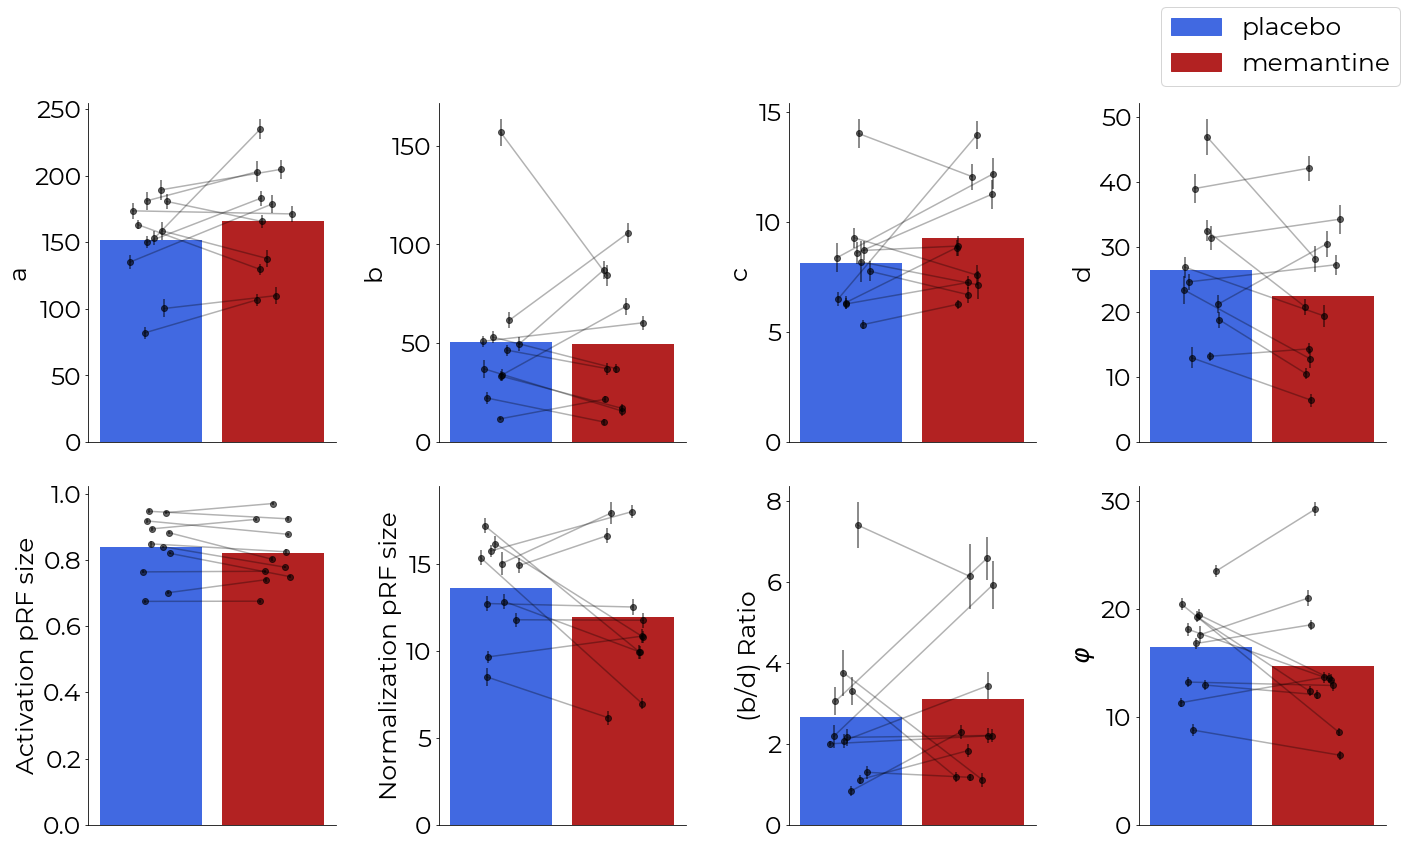

In [75]:
fig, axes = plt.subplots(2,4, figsize=(20, 11))
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 25})

params_title = {'A':'a', 'B':'b', 'C':'c','D':'d', 'prf_size':'Activation pRF size', 'surr_size': 'Normalization pRF size', 'size ratio': '$φ$', 'ratio (B/D)': '(b/d) Ratio'}

for k,metric in enumerate(['A', 'B', 'C', 'D', 'prf_size','surr_size', 'ratio (B/D)', 'size ratio']):
    ax = axes[k//4,k%4]

    param_means = {condition: [meandict_params[sub][condition][metric]['mean'] for sub in newsubs] for condition in ['placebo','memantine']}

    ax.bar(0.1, np.array(param_means['placebo']).mean(), width=0.1, color='royalblue')
    ax.bar(0.22, np.array(param_means['memantine']).mean(), width=0.1, color='firebrick')

    for sub in newsubs:   
        # FIRST PLOT MEANS, THEN CONNECT THEM
        plac_value = (0.1 + random.uniform(-0.02, 0.02), meandict_params[sub]['placebo'][metric]['mean'])
        mem_value = (0.22 + random.uniform(-0.02, 0.02), meandict_params[sub]['memantine'][metric]['mean'])

        ax.scatter(plac_value[0], plac_value[1], color='black', alpha=0.6)
        ax.scatter(mem_value[0], mem_value[1], color='black', alpha=0.6)

        #Plot line between points
        ax.plot([plac_value[0], mem_value[0]], [plac_value[1], mem_value[1]], color='black', alpha=0.3)

        #Plot error bar for each point
        ax.vlines(plac_value[0],ymin=plac_value[1]-meandict_params[sub]['placebo'][metric]['sem'], ymax=plac_value[1]+meandict_params[sub]['placebo'][metric]['sem'], color='black', alpha=0.6)
        ax.vlines(mem_value[0],ymin=mem_value[1]-meandict_params[sub]['memantine'][metric]['sem'], ymax=mem_value[1]+meandict_params[sub]['memantine'][metric]['sem'], color='black', alpha=0.6)

    ax.set_ylabel(f'{params_title[metric]}', fontsize=25)
    ax.set_xticks([])


sns.despine()
fig.legend(handles=[placebo_patch, memantine_patch], loc='upper right', ncol=1, fontsize=25, bbox_to_anchor=[0, 0, 1, 1.1])
fig.tight_layout()

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/V1_parameters_new.png"

plt.savefig(save_path, bbox_inches='tight', dpi=300)

fig.show()

Now, test the metrics statistically as well:

In [72]:
for metric in metrics:
    print("Now testing", metric)
    param_means = {condition: [meandict_params[sub][condition][metric]['mean'] for sub in newsubs] for condition in ['placebo','memantine']}

    print("Placebo mean:", np.mean(param_means['placebo']))
    print("Memantine mean:", np.mean(param_means['memantine']))
    
    print(ttest_rel(param_means['placebo'],param_means['memantine']))
    print("")

Now testing A
Placebo mean: 151.51601084068272
Memantine mean: 165.9082998327109
Ttest_relResult(statistic=-1.465896575541381, pvalue=0.17340167696156483)

Now testing B
Placebo mean: 50.65863187303198
Memantine mean: 49.57644716717883
Ttest_relResult(statistic=0.10738589641606204, pvalue=0.9166067768141322)

Now testing C
Placebo mean: 8.11696952156114
Memantine mean: 9.275494735249104
Ttest_relResult(statistic=-1.3642421494134407, pvalue=0.20240503324276113)

Now testing D
Placebo mean: 26.449208865037576
Memantine mean: 22.42041318941041
Ttest_relResult(statistic=1.5945177724972825, pvalue=0.14190435250722155)

Now testing prf_size
Placebo mean: 0.8392828437840879
Memantine mean: 0.821047635763837
Ttest_relResult(statistic=1.4550407802273875, pvalue=0.17631873976209037)

Now testing surr_size
Placebo mean: 13.64819320549931
Memantine mean: 11.969108108989643
Ttest_relResult(statistic=1.4203173601557484, pvalue=0.18593412903881057)

Now testing size ratio
Placebo mean: 16.50388037154